### CS 487/519 Applied Machine Learning I
#### Machine Learning Project
##### Team No: 03
##### Team Members:
1. Nishan Rai 
2. Pushparaj Dahal


##### Dataset
##### BRaTS 2021 Dataset: https://www.kaggle.com/datasets/dschettler8845/brats-2021-task1
##### LIDC-IDRI Dataset: https://www.kaggle.com/datasets/zhangweiled/lidcidri?select=LIDC-IDRI-slices

##### Setup and Configuration
Here we define paths and check for GPU availablity.

In [36]:
import torch
import numpy as np
import random

# Set seed for reproducibility
def set_seed(seed=42):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True  # slower but reproducible
    torch.backends.cudnn.benchmark = False

set_seed(42)


In [37]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [38]:
import torch
print("GPU Available:", torch.cuda.is_available())
print("GPU Name:", torch.cuda.get_device_name(0))

GPU Available: True
GPU Name: NVIDIA H100 NVL


##### Explore Extracted Files
We inspect the contents of the extracted BraTs dataset directory

In [39]:
import os

print("Files inside extracted folder:")
print(os.listdir("Data/BraTS2021_00495"))


Files inside extracted folder:
['BraTS2021_00495_t1ce.nii.gz', 'BraTS2021_00495_flair.nii.gz', 'BraTS2021_00495_t2.nii.gz', 'BraTS2021_00495_seg.nii.gz', 'BraTS2021_00495_t1.nii.gz']


##### Load the NIfTI Files
This step loads the MRI scans and their corresponding segmentation masks.

In [40]:
import nibabel as nib
import os

multi_brats_path = "/home/simurghnobackup/nrai/BraTS2021_Training_Data"

# List all patient folders
all_patient_dirs = [os.path.join(multi_brats_path, d) for d in os.listdir(multi_brats_path) if os.path.isdir(os.path.join(multi_brats_path, d))]
print("Total patients found:", len(all_patient_dirs))


Total patients found: 1251


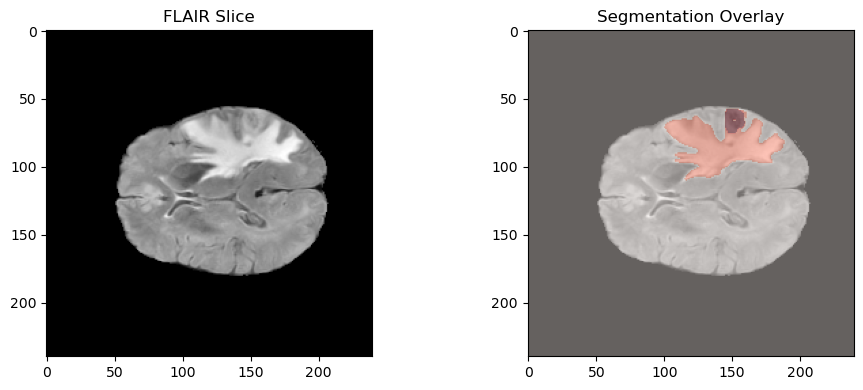

In [41]:
import nibabel as nib
import matplotlib.pyplot as plt
import os

# Select one patient (e.g., the first one)
sample_patient_dir = all_patient_dirs[0]

# Load modalities and segmentation mask
flair = nib.load(os.path.join(sample_patient_dir, os.path.basename(sample_patient_dir) + "_flair.nii.gz"))
seg = nib.load(os.path.join(sample_patient_dir, os.path.basename(sample_patient_dir) + "_seg.nii.gz"))

# Convert to NumPy
flair_data = flair.get_fdata()
seg_data = seg.get_fdata()

# Pick a middle slice
slice_idx = flair_data.shape[2] // 2

# Plot
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.imshow(flair_data[:, :, slice_idx], cmap="gray")
plt.title("FLAIR Slice")

plt.subplot(1, 2, 2)
plt.imshow(flair_data[:, :, slice_idx], cmap="gray")
plt.imshow(seg_data[:, :, slice_idx], cmap="Reds", alpha=0.4)
plt.title("Segmentation Overlay")

plt.tight_layout()
plt.show()


##### Convert NIfTI to NumPy and Normalize

In [42]:
import os
import nibabel as nib
import numpy as np
from torch.utils.data import Dataset

# Dataset path
multi_brats_path = "/home/simurghnobackup/nrai/BraTS2021_Training_Data"
all_patient_dirs = [os.path.join(multi_brats_path, d) for d in os.listdir(multi_brats_path) if os.path.isdir(os.path.join(multi_brats_path, d))]
print("Total patients found:", len(all_patient_dirs))

# Normalization function
def normalize(img):
    return (img - np.min(img)) / (np.max(img) - np.min(img) + 1e-8)

# Custom Dataset class for all patients
class BraTS2021Dataset(Dataset):
    def __init__(self, patient_dirs, transform=None):
        self.transform = transform
        self.data = []  # Will hold (volume, mask) tuples as slices

        for p in patient_dirs:
            pid = os.path.basename(p)
            try:
                flair = normalize(nib.load(os.path.join(p, f"{pid}_flair.nii.gz")).get_fdata())
                t1    = normalize(nib.load(os.path.join(p, f"{pid}_t1.nii.gz")).get_fdata())
                t1ce  = normalize(nib.load(os.path.join(p, f"{pid}_t1ce.nii.gz")).get_fdata())
                t2    = normalize(nib.load(os.path.join(p, f"{pid}_t2.nii.gz")).get_fdata())
                seg   = nib.load(os.path.join(p, f"{pid}_seg.nii.gz")).get_fdata()

                volume = np.stack([t1, t1ce, t2, flair], axis=0)  # Shape: [4, H, W, D]
                for idx in range(volume.shape[3]):
                    x = volume[:, :, :, idx]     # [4, H, W]
                    y = seg[:, :, idx]           # [H, W]
                    self.data.append((x, y))

            except Exception as e:
                print(f"Skipping {pid}: {e}")

        print(f"Total slices prepared: {len(self.data)}")

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        x, y = self.data[idx]  # x: [4, H, W], y: [H, W]
        if self.transform:
            x_hwc = x.transpose(1, 2, 0)  # [H, W, 4]
            augmented = self.transform(image=x_hwc, mask=y)
            x = augmented["image"]
            y = augmented["mask"]
            if y.ndim == 2:
                y = y.unsqueeze(0)
        else:
            x = torch.from_numpy(x).float()
            y = torch.from_numpy(y).unsqueeze(0).float()
        return x, y


Total patients found: 1251


##### Prepare BraTs Dataset

In [43]:
# ! pip install albumentations

##### Defie Unified Transforms

In [44]:
import albumentations as A
from albumentations.pytorch import ToTensorV2

# Common parameters for both datasets
UNIFIED_SIZE = (128, 128)  # Same for BraTS and LIDC
COMMON_MEAN = 0.0
COMMON_STD = 1.0

# Shared training augmentations
train_transform = A.Compose([
    A.Resize(*UNIFIED_SIZE),
    A.HorizontalFlip(p=0.5),
    A.RandomRotate90(p=0.5),
    A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.1, rotate_limit=15, p=0.5),
    A.RandomBrightnessContrast(p=0.3),
    A.ElasticTransform(p=0.2),
    A.GridDistortion(p=0.2),
    A.CoarseDropout(max_holes=8, max_height=16, max_width=16, p=0.3),
    A.Normalize(mean=COMMON_MEAN, std=COMMON_STD),
    ToTensorV2()
])

# Shared validation transforms
val_transform = A.Compose([
    A.Resize(*UNIFIED_SIZE),
    A.Normalize(mean=COMMON_MEAN, std=COMMON_STD),
    ToTensorV2()
])

# Apply to both datasets
brats_transform = train_transform  # BraTS uses same as LIDC
lidc_transform = train_transform   # LIDC uses same as BraTS


/tmp/ipykernel_8542/2238648527.py:18: UserWarning: Argument(s) 'max_holes, max_height, max_width' are not valid for transform CoarseDropout
  A.CoarseDropout(max_holes=8, max_height=16, max_width=16, p=0.3),


In [45]:
brats_transform_light = A.Compose([
    A.Resize(128, 128),
    A.HorizontalFlip(p=0.5),
    A.RandomRotate90(p=0.5),
    A.Normalize(mean=0.0, std=1.0),
    ToTensorV2()
])



In [46]:
import os
import random
import torch
import nibabel as nib
import numpy as np
from torch.utils.data import Dataset, DataLoader
from scipy.ndimage import zoom
import matplotlib.pyplot as plt

# Dataset path setup
multi_brats_path = "/home/simurghnobackup/nrai/BraTS2021_Training_Data"
all_patient_dirs = [os.path.join(multi_brats_path, d) 
                   for d in os.listdir(multi_brats_path) 
                   if os.path.isdir(os.path.join(multi_brats_path, d))]
print("Total patients found:", len(all_patient_dirs))

# Select subset of patients
num_patients = 200  # ADJUST THIS TO CONTROL DATASET SIZE
random.seed(42)  # For reproducibility
selected_patients = random.sample(all_patient_dirs, num_patients)
print(f"Using {len(selected_patients)} patients from {len(all_patient_dirs)} total")

# Custom Dataset Class
class MultiSubjectBraTSDataset(Dataset):
    def __init__(self, patient_dirs, transform=None, 
                 slice_skip=4):
        self.tumor_slices = []
        self.non_tumor_slices = []
        self.transform = transform
        
        for path in patient_dirs:
            try:
                pid = os.path.basename(path)
                seg_path = os.path.join(path, f"{pid}_seg.nii.gz")
                seg_data = nib.load(seg_path).get_fdata()
                seg_data = (seg_data > 0).astype(np.float32)

                for i in range(0, seg_data.shape[-1], slice_skip):
                    slice_mask = seg_data[:, :, i]
                    tumor_ratio = slice_mask.sum() / slice_mask.size
                    entry = (
                        os.path.join(path, f"{pid}_flair.nii.gz"),
                        os.path.join(path, f"{pid}_t1.nii.gz"),
                        os.path.join(path, f"{pid}_t1ce.nii.gz"),
                        os.path.join(path, f"{pid}_t2.nii.gz"),
                        seg_path,
                        i
                    )
                    if tumor_ratio >= 0.05:
                        self.tumor_slices.append(entry)
                    else:
                        self.non_tumor_slices.append(entry)
            except Exception as e:
                print(f"Skipping {path}: {str(e)}")

        self.slices = self.tumor_slices + self.non_tumor_slices
        print(f"Tumor slices: {len(self.tumor_slices)}, Non-tumor slices: {len(self.non_tumor_slices)}")


    def __len__(self):
        return len(self.slices)

    def __getitem__(self, idx):
        # Unpack paths and slice index
        flair_path, t1_path, t1ce_path, t2_path, seg_path, slice_idx = self.slices[idx]
        
        # Load and process segmentation mask
        seg = nib.load(seg_path).get_fdata()[:, :, slice_idx]
        seg = (seg > 0).astype(np.float32)  # Binary mask

        # Load and normalize modalities
        def load_modality(path):
            img = nib.load(path).get_fdata()[:, :, slice_idx]
            return (img - img.min()) / (img.max() - img.min() + 1e-8)
            
        flair = load_modality(flair_path)
        t1 = load_modality(t1_path)
        t1ce = load_modality(t1ce_path)
        t2 = load_modality(t2_path)

        # Stack modalities and handle transforms
        x = np.stack([t1, t1ce, t2, flair], axis=0)  # [4, H, W]
        y = seg  # [H, W]

        if self.transform:
            x_hwc = x.transpose(1, 2, 0)  # [H, W, 4]
            augmented = self.transform(image=x_hwc, mask=y)
            x = augmented["image"]
            y = augmented["mask"].unsqueeze(0)
        else:
            x = torch.from_numpy(x).float()
            y = torch.from_numpy(y).float().unsqueeze(0)

        return x, y

def visualize_sample(dataset, num_samples=3):
    """Visualize sample data slices"""
    plt.figure(figsize=(15, 5*num_samples))
    for i in range(num_samples):
        x, y = dataset[i]
        
        # Plot first modality channel
        plt.subplot(num_samples, 2, i*2+1)
        plt.imshow(x[0], cmap='gray')
        plt.title(f"Modality Slice {i+1}")
        
        # Plot corresponding mask
        plt.subplot(num_samples, 2, i*2+2)
        plt.imshow(y.squeeze(), cmap='jet')
        plt.title(f"Tumor Mask {i+1}")
    plt.tight_layout()
    plt.show()

# Create reduced dataset
dataset = MultiSubjectBraTSDataset(
    selected_patients,
    transform=None,
    slice_skip=4  # Only pass this if needed
)

print("Dataset created with", len(dataset), "samples")

Total patients found: 1251
Using 200 patients from 1251 total
Tumor slices: 467, Non-tumor slices: 7333
Dataset created with 7800 samples


In [47]:
from torch.utils.data import random_split, DataLoader

# Get actual length of dataset
total_len = len(dataset)

# Proportional split (same ratios as 10883:2332:2333)
train_ratio = 0.7
val_ratio = 0.15
test_ratio = 0.15

train_len = int(train_ratio * total_len)
val_len = int(val_ratio * total_len)
test_len = total_len - train_len - val_len  # Remaining

# Perform the initial split
brats_train, brats_val, brats_test = random_split(
    dataset, [train_len, val_len, test_len],
    generator=torch.Generator().manual_seed(42)
)


# Inject transforms AFTER filtering
brats_train.dataset.transform = train_transform
brats_val.dataset.transform   = val_transform
brats_test.dataset.transform  = val_transform

train_loader_brats = DataLoader(brats_train, batch_size=8, shuffle=True, num_workers=4, pin_memory=True)
val_loader_brats   = DataLoader(brats_val, batch_size=8, shuffle=False, num_workers=4, pin_memory=True)
test_loader_brats  = DataLoader(brats_test, batch_size=8, shuffle=False, num_workers=4, pin_memory=True)

print("BraTS Dataset and DataLoaders created:")
print("Train size:", len(brats_train))
print("Val size:", len(brats_val))
print("Test size:", len(brats_test))



BraTS Dataset and DataLoaders created:
Train size: 5460
Val size: 1170
Test size: 1170


##### Print the data split for train test and validation

In [48]:
print("Train:", len(brats_train))
print("Val:", len(brats_val))
print("Test:", len(brats_test))

# Works only if dataset is a Subset or random_split result
train_ids = set(brats_train.indices)
val_ids   = set(brats_val.indices)
test_ids  = set(brats_test.indices)

assert train_ids.isdisjoint(val_ids)
assert train_ids.isdisjoint(test_ids)
assert val_ids.isdisjoint(test_ids)

print("No overlap – reproducible split")




Train: 5460
Val: 1170
Test: 1170
No overlap – reproducible split


##### Define the UNet model

In [49]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# Basic double conv block
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.block = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(inplace=True)
        )

    def forward(self, x):
        return self.block(x)

# Attention gate block
class AttentionBlock(nn.Module):
    def __init__(self, F_g, F_l, F_int):
        super(AttentionBlock, self).__init__()
        self.W_g = nn.Sequential(
            nn.Conv2d(F_g, F_int, kernel_size=1, bias=True),
            nn.BatchNorm2d(F_int)
        )

        self.W_x = nn.Sequential(
            nn.Conv2d(F_l, F_int, kernel_size=1, bias=True),
            nn.BatchNorm2d(F_int)
        )

        self.psi = nn.Sequential(
            nn.Conv2d(F_int, 1, kernel_size=1, bias=True),
            nn.BatchNorm2d(1),
            nn.Sigmoid()
        )

        self.relu = nn.ReLU(inplace=True)

    def forward(self, g, x):
        g1 = self.W_g(g)
        x1 = self.W_x(x)
        psi = self.relu(g1 + x1)
        psi = self.psi(psi)
        return x * psi

# Attention U-Net
class AttentionUNet(nn.Module):
    def __init__(self, in_channels=4, out_channels=1, features=[64, 128, 256]):
        super(AttentionUNet, self).__init__()
        self.encoder1 = DoubleConv(in_channels, features[0])
        self.pool1 = nn.MaxPool2d(2)
        self.encoder2 = DoubleConv(features[0], features[1])
        self.pool2 = nn.MaxPool2d(2)

        self.bottleneck = DoubleConv(features[1], features[2])

        self.up2 = nn.ConvTranspose2d(features[2], features[1], kernel_size=2, stride=2)
        self.att2 = AttentionBlock(F_g=features[1], F_l=features[1], F_int=features[1] // 2)
        self.decoder2 = DoubleConv(features[2], features[1])

        self.up1 = nn.ConvTranspose2d(features[1], features[0], kernel_size=2, stride=2)
        self.att1 = AttentionBlock(F_g=features[0], F_l=features[0], F_int=features[0] // 2)
        self.decoder1 = DoubleConv(features[1], features[0])

        self.final_conv = nn.Conv2d(features[0], out_channels, kernel_size=1)

        self.dropout = nn.Dropout2d(0.3)

    def forward(self, x):
        enc1 = self.encoder1(x)
        enc2 = self.encoder2(self.pool1(enc1))

        bottleneck = self.bottleneck(self.pool2(enc2))
        bottleneck = self.dropout(bottleneck)

        up2 = self.up2(bottleneck)
        att2 = self.att2(g=up2, x=enc2)
        dec2 = self.decoder2(torch.cat([up2, att2], dim=1))

        up1 = self.up1(dec2)
        att1 = self.att1(g=up1, x=enc1)
        dec1 = self.decoder1(torch.cat([up1, att1], dim=1))

        return self.final_conv(dec1)


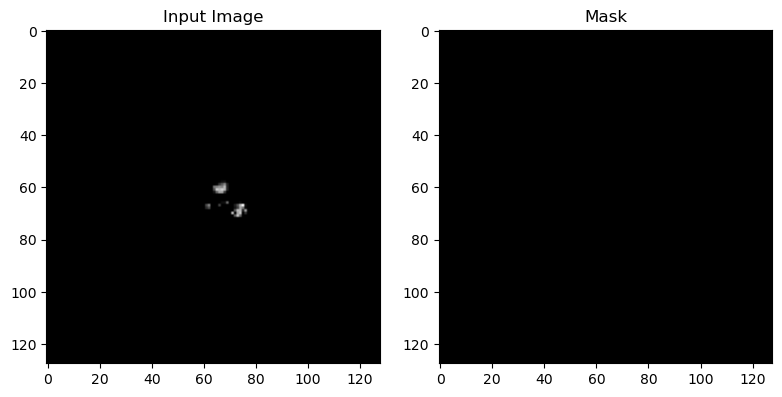

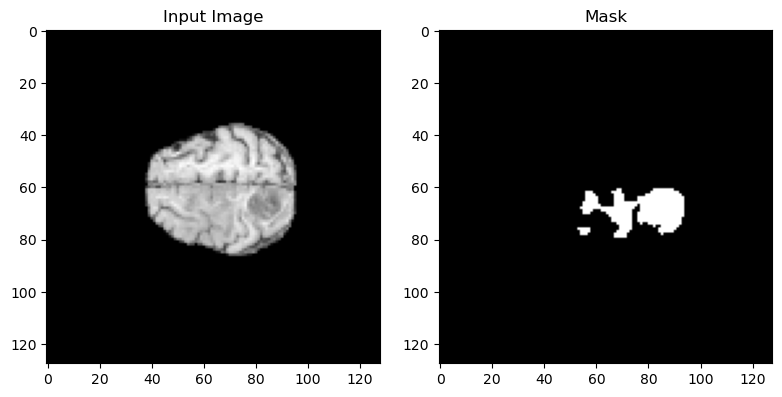

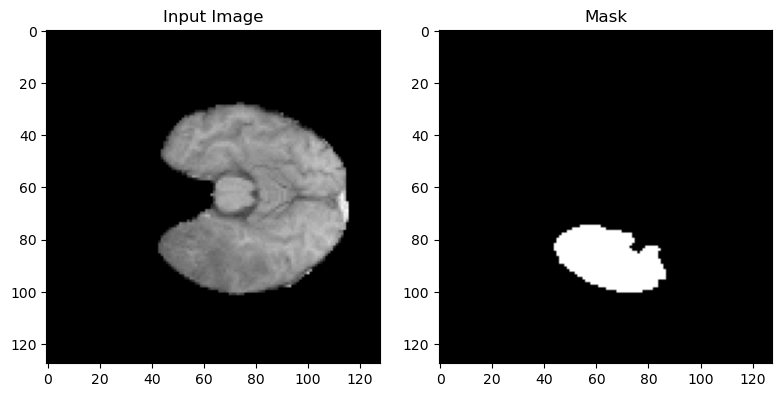

In [50]:
def sanity_check_dataloader(loader, num_samples=3):
    for x, y in loader:
        for i in range(min(num_samples, x.size(0))):  # avoid out-of-bounds
            plt.figure(figsize=(8, 4))

            plt.subplot(1, 2, 1)
            plt.imshow(x[i, 0].cpu(), cmap='gray')
            plt.title("Input Image")

            plt.subplot(1, 2, 2)
            mask = y[i]
            if mask.ndim == 3:
                mask = mask[0]  # [1, H, W] → [H, W]
            plt.imshow(mask.cpu(), cmap='gray')
            plt.title("Mask")

            plt.tight_layout()
            plt.show()
        break


# Call it
sanity_check_dataloader(train_loader_brats)


In [51]:
# Instantiate the model
model = AttentionUNet(in_channels=4, out_channels=1).cuda()


In [52]:
# Print model summary
print(model)


AttentionUNet(
  (encoder1): DoubleConv(
    (block): Sequential(
      (0): Conv2d(4, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.01, inplace=True)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): LeakyReLU(negative_slope=0.01, inplace=True)
    )
  )
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (encoder2): DoubleConv(
    (block): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.01, inplace=True)
      (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1),

In [53]:
# Dummy input with batch size = 1, 4 input channels, 128x128 spatial size
x_dummy = torch.randn(1, 4, 128, 128).cuda()
output = model(x_dummy)
print("Output shape:", output.shape)
print("Output min:", output.min().item())
print("Output max:", output.max().item())
print("Output mean:", output.mean().item())


Output shape: torch.Size([1, 1, 128, 128])
Output min: -1.6276068687438965
Output max: 1.0717791318893433
Output mean: -0.191175177693367


##### Loading and preprocessing IDC-IDRI Dataset

In [54]:
import os

# List all files and match the ZIP file exactly
files = os.listdir("Data")
zip_filename = [f for f in files if f.lower().endswith(".zip") and "lidc" in f.lower()]
print("Found zip file(s):", zip_filename)


Found zip file(s): ['LIDC-IDRI.zip']


In [55]:
'''' import zipfile

zip_path = os.path.join("Data", zip_filename[0])
extract_path = "Data/LIDC-IDRI"

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print("Extracted to:", extract_path) '''


'\' import zipfile\n\nzip_path = os.path.join("Data", zip_filename[0])\nextract_path = "Data/LIDC-IDRI"\n\nwith zipfile.ZipFile(zip_path, \'r\') as zip_ref:\n    zip_ref.extractall(extract_path)\n\nprint("Extracted to:", extract_path) '

torch.Size([4, 128, 128]) torch.Size([1, 128, 128])


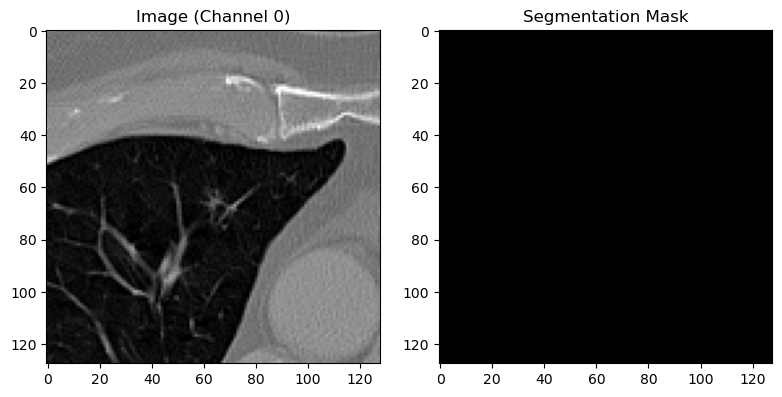

In [56]:
import torch
from torch.utils.data import Dataset
import os
from PIL import Image
import numpy as np

class LIDCIDRIDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        """
        Args:
            root_dir (str): Path to the root directory containing patient folders.
            transform (albumentations.Compose): Albumentations transform applied to both image and mask.
        """
        self.root_dir = root_dir
        self.transform = transform
        self.samples = []  # List of (image_path, [mask_paths])

        for patient_id in os.listdir(self.root_dir):
            patient_dir = os.path.join(self.root_dir, patient_id)
            for nodule_id in os.listdir(patient_dir):
                nodule_dir = os.path.join(patient_dir, nodule_id)
                image_dir = os.path.join(nodule_dir, 'images')
                mask_dirs = [os.path.join(nodule_dir, f'mask-{i}') for i in range(4)]

                image_files = sorted(os.listdir(image_dir))
                for img_file in image_files:
                    img_path = os.path.join(image_dir, img_file)
                    mask_paths = [os.path.join(mdir, img_file) for mdir in mask_dirs]
                    self.samples.append((img_path, mask_paths))

    def __len__(self):
        return len(self.samples)

    def load_image(self, path):
        return Image.open(path).convert('L')

    def load_and_combine_masks(self, mask_paths):
        masks = []
        for mask_path in mask_paths:
            if os.path.exists(mask_path):
                mask = Image.open(mask_path).convert('L')
                mask = np.array(mask) > 0
                masks.append(mask.astype(np.uint8))
            else:
                # All-zero mask fallback
                if masks:
                    masks.append(np.zeros_like(masks[0]))
                else:
                    masks.append(np.zeros((512, 512), dtype=np.uint8))  # or infer size from dataset
        combined = np.mean(masks, axis=0)
        combined = (combined >= 0.5).astype(np.uint8)
        return combined * 255  # to match image pixel intensity

    def __getitem__(self, idx):
        img_path, mask_paths = self.samples[idx]
        
        # Load and combine masks
        image = np.array(Image.open(img_path).convert('L')).astype(np.float32)
        image = (image - image.mean()) / (image.std() + 1e-8)
        image = np.clip(image, -3, 3)  # Optional: stabilize outliers

        masks = [np.array(Image.open(p).convert('L')) > 0 if os.path.exists(p) 
                else np.zeros_like(image) for p in mask_paths]
        mask = (np.mean(masks, axis=0) > 0.25).astype(np.float32)

        # Process and transform
        image = np.stack([image]*4, axis=-1)  # Create 4-channel input
        if self.transform:
            augmented = self.transform(image=image, mask=mask)
            image = augmented["image"]
            mask = augmented["mask"].unsqueeze(0)
        else:
            image = torch.from_numpy(image.transpose(2, 0, 1)).float() / 255.0
            mask = torch.from_numpy(mask).unsqueeze(0).float() / 255.0
            
        return image, mask

# Load the dataset
dataset_path = "Data/LIDC-IDRI/LIDC-IDRI-slices"
dataset = LIDCIDRIDataset(dataset_path, transform=val_transform)

# Preview a sample
image, mask = dataset[50]
print(image.shape, mask.shape)  # Should be [4, 128, 128], [1, 128, 128]

# Sanity check: Visualize
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.imshow(image[0].cpu(), cmap='gray')
plt.title("Image (Channel 0)")

plt.subplot(1, 2, 2)
plt.imshow(mask[0].cpu(), cmap='gray')
plt.title("Segmentation Mask")

plt.tight_layout()
plt.show()



### Data loader for training (LIDC)

In [57]:
from torch.utils.data import random_split, DataLoader

# Split LIDC dataset
total_len = len(dataset)
train_len = int(0.7 * total_len)
val_len = int(0.15 * total_len)
test_len = total_len - train_len - val_len

# Changed variable names here
lidc_train, lidc_val, lidc_test = random_split(
    dataset, [train_len, val_len, test_len],
    generator=torch.Generator().manual_seed(42)
)

# Inject transforms
lidc_train.dataset.transform = train_transform
lidc_val.dataset.transform = val_transform
lidc_test.dataset.transform = val_transform

# Update DataLoader creation with new variable names
train_loader_lidc = DataLoader(lidc_train, batch_size=8, shuffle=True)
val_loader_lidc = DataLoader(lidc_val, batch_size=8, shuffle=False)
test_loader_lidc = DataLoader(lidc_test, batch_size=8, shuffle=False)

print("LIDC Dataset splits:")
print(f"Train size: {len(lidc_train)}")
print(f"Val size: {len(lidc_val)}")
print(f"Test size: {len(lidc_test)}")


LIDC Dataset splits:
Train size: 10883
Val size: 2332
Test size: 2333


#### Unified Training loop

In [ ]:
import torch
import torch.nn as nn
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, ConcatDataset, random_split, Sampler
import time


#  Stabilized Components
def dice_score(preds, targets, threshold=0.2, smooth=1e-3):
    preds = torch.sigmoid(preds)
    preds = (preds > threshold).float()
    
    # Ensure dimensions [B, C, H, W]
    if preds.ndim == 3: preds = preds.unsqueeze(1)
    if targets.ndim == 3: targets = targets.unsqueeze(1)
    
    intersection = (preds * targets).sum(dim=(1,2,3))
    union = preds.sum(dim=(1,2,3)) + targets.sum(dim=(1,2,3))
    return ((2. * intersection + smooth) / (union + smooth)).mean().item()

class FocalTverskyLoss(nn.Module):
    def __init__(self, alpha=0.7, beta=0.3, gamma=0.75, smooth=1e-2):
        super().__init__()
        self.alpha = alpha
        self.beta = beta
        self.gamma = gamma
        self.smooth = smooth

    def forward(self, preds, targets):
        probs = torch.sigmoid(preds)
        probs = torch.clamp(probs, min=1e-4, max=1-1e-4)
        targets = targets.float()

        TP = (probs * targets).sum()
        FP = ((1 - targets) * probs).sum()
        FN = (targets * (1 - probs)).sum()

        denom = TP + self.alpha * FN + self.beta * FP + self.smooth
        denom = torch.clamp(denom, min=1e-6)

        return ((1 - (TP + self.smooth) / denom) ** self.gamma).clamp_max(10)


# Balanced Sampling 
class BalancedSampler(Sampler):
    def __init__(self, brats_source, lidc_source, batch_size=8):
        self.brats_len = len(brats_source)
        self.lidc_len = len(lidc_source)
        self.batch_size = batch_size
        
        # Create index pools with offsets
        self.brats_indices = np.arange(self.brats_len)
        self.lidc_indices = np.arange(self.lidc_len) + self.brats_len  # Critical offset

    def __iter__(self):
        # Generate permuted indices
        brats_perm = np.random.permutation(self.brats_indices)
        lidc_perm = np.random.permutation(self.lidc_indices)
        
        # Create balanced batches
        batches = []
        for i in range(0, min(len(brats_perm), len(lidc_perm)), self.batch_size//2):
            batch = np.concatenate([
                brats_perm[i:i+self.batch_size//2],
                lidc_perm[i:i+self.batch_size//2]
            ])
            np.random.shuffle(batch)
            batches.append(batch)
            
        return iter(batches)

    def __len__(self):
        return min(self.brats_len, self.lidc_len) // (self.batch_size//2)

# Enhanced Training Loop 
def unified_train_model(model, train_loader, val_loaders, num_epochs=30, lr=3e-5):
    import time  # optional if you already added it above
    start_time = time.time()  # Start timer
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=1e-5)
    scheduler = torch.optim.lr_scheduler.OneCycleLR(
        optimizer,
        max_lr=lr*3,
        epochs=num_epochs,
        steps_per_epoch=len(train_loader)
    )

    criterion = {
        'brats': FocalTverskyLoss(alpha=0.8, beta=0.2),
        'lidc': FocalTverskyLoss(alpha=0.5, beta=0.5)
    }
    
    hist = {
        'train_loss': [], 'train_dice': [],
        'val_brats': [], 'val_lidc': [],
        'best_dice': 0.0
    }

    # Early stopping config 
    early_stop_patience = 3
    early_stop_min_delta = 1e-3
    best_dice = 0.0
    patience_counter = 0

    for epoch in range(num_epochs):
        model.train()
        epoch_loss, epoch_dice = 0, 0
        
        pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}")
        for x, y in pbar:
            x, y = x.to(device), y.to(device)

            # Balanced batch split
            brats_x, brats_y = x[:len(x)//2], y[:len(y)//2]
            lidc_x, lidc_y = x[len(x)//2:], y[len(y)//2:]

            # Forward
            brats_pred = model(brats_x)
            lidc_pred = model(lidc_x)

            loss_brats = criterion['brats'](brats_pred, brats_y)
            loss_lidc = criterion['lidc'](lidc_pred, lidc_y)
            loss = 0.4 * loss_brats + 0.6 * loss_lidc

            if torch.isnan(loss):
                print("NaN loss detected, skipping batch")
                continue

            optimizer.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()

            if scheduler.last_epoch + 1 < scheduler.total_steps:
                scheduler.step()

            with torch.no_grad():
                dice = 0.5 * (dice_score(brats_pred, brats_y) + dice_score(lidc_pred, lidc_y))

            epoch_loss += loss.item()
            epoch_dice += dice
            pbar.set_postfix(loss=loss.item(), dice=dice, lr=optimizer.param_groups[0]['lr'])

        # Validation 
        model.eval()
        val_metrics = {}
        with torch.no_grad():
            for name, loader in zip(['brats', 'lidc'], val_loaders):
                total_loss, total_dice = 0, 0
                for x, y in loader:
                    x, y = x.to(device), y.to(device)
                    preds = model(x)

                    loss = criterion[name](preds, y)
                    total_loss += loss.item()
                    total_dice += dice_score(preds, y)

                val_metrics[name] = (
                    total_loss / len(loader),
                    total_dice / len(loader)
                )

        hist['train_loss'].append(epoch_loss / len(train_loader))
        hist['train_dice'].append(epoch_dice / len(train_loader))
        hist['val_brats'].append(val_metrics['brats'])
        hist['val_lidc'].append(val_metrics['lidc'])

        print(f"\nEpoch {epoch+1}/{num_epochs}")
        print(f"Train Loss: {hist['train_loss'][-1]:.4f} | Dice: {hist['train_dice'][-1]:.4f}")
        print(f"BraTS Val Loss: {val_metrics['brats'][0]:.4f} | Dice: {val_metrics['brats'][1]:.4f}")
        print(f"LIDC Val Loss: {val_metrics['lidc'][0]:.4f} | Dice: {val_metrics['lidc'][1]:.4f}")

        # Early Stopping Check 
        avg_dice = (val_metrics['brats'][1] + val_metrics['lidc'][1]) / 2
        improvement = avg_dice - best_dice

        if improvement > early_stop_min_delta:
            best_dice = avg_dice
            hist['best_dice'] = best_dice
            patience_counter = 0
            torch.save(model.state_dict(), "best_model.pth")
            print("Saved new best model!")
        else:
            patience_counter += 1
            print(f"No significant improvement. Patience: {patience_counter}/{early_stop_patience}")
            if patience_counter >= early_stop_patience:
                print("Early stopping triggered!")
                break

        # Visualization Every 5 Epochs 
        if (epoch + 1) % 5 == 0:
            visualize_predictions(model, val_loaders[0], device, title=f"BraTS Epoch {epoch+1}")
            visualize_predictions(model, val_loaders[1], device, title=f"LIDC Epoch {epoch+1}")
            
    total_time = time.time() - start_time
    minutes, seconds = divmod(total_time, 60)
    print(f"\nTotal Training Time: {int(minutes)} minutes {int(seconds)} seconds")


    return hist


# Visualization Function 
def visualize_predictions(model, loader, device, num_samples=3, title=""):
    model.eval()
    fig, axs = plt.subplots(num_samples, 3, figsize=(15, 5*num_samples))
    
    with torch.no_grad():
        shown = 0
        for x, y in loader:
            x, y = x.to(device), y.cpu().numpy()
            preds = torch.sigmoid(model(x)).cpu().numpy()
            x = x.cpu().numpy()
            
            for i in range(x.shape[0]):
                if shown >= num_samples: break
                
                # Input (first channel)
                axs[shown,0].imshow(x[i,0], cmap='gray')
                axs[shown,0].set_title("Input")
                
                # Ground Truth
                axs[shown,1].imshow(y[i,0], cmap='gray')
                axs[shown,1].set_title("GT")
                
                # Prediction
                axs[shown,2].imshow(preds[i,0] > 0.5, cmap='gray')
                axs[shown,2].set_title("Prediction")
                
                shown += 1
            if shown >= num_samples: break
    
    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

Starting LIDC pretraining...
LIDC Pretrain Epoch 1 | Avg Loss: 0.8864
LIDC Pretrain Epoch 2 | Avg Loss: 0.5775
LIDC Pretrain Epoch 3 | Avg Loss: 0.4938
LIDC Pretrain Epoch 4 | Avg Loss: 0.4690
LIDC Pretrain Epoch 5 | Avg Loss: 0.4492
LIDC pretraining complete and saved.


Epoch 1/45: 100%|██████████| 1365/1365 [05:21<00:00,  4.25it/s, dice=0.599, loss=0.299, lr=1.59e-5] 



Epoch 1/45
Train Loss: 0.7012 | Dice: 0.4986
BraTS Val Loss: 0.9998 | Dice: 0.5765
LIDC Val Loss: 0.4439 | Dice: 0.5419
Saved new best model!


Epoch 2/45: 100%|██████████| 1365/1365 [05:21<00:00,  4.25it/s, dice=0.754, loss=0.489, lr=2.73e-5]  



Epoch 2/45
Train Loss: 0.5702 | Dice: 0.5417
BraTS Val Loss: 0.5020 | Dice: 0.7166
LIDC Val Loss: 0.4486 | Dice: 0.5240
Saved new best model!


Epoch 3/45: 100%|██████████| 1365/1365 [05:20<00:00,  4.25it/s, dice=0.847, loss=0.266, lr=4.57e-5] 



Epoch 3/45
Train Loss: 0.4662 | Dice: 0.6040
BraTS Val Loss: 0.4547 | Dice: 0.7856
LIDC Val Loss: 0.4474 | Dice: 0.5292
Saved new best model!


Epoch 4/45: 100%|██████████| 1365/1365 [05:19<00:00,  4.28it/s, dice=0.6, loss=0.525, lr=7e-5]     



Epoch 4/45
Train Loss: 0.4371 | Dice: 0.6295
BraTS Val Loss: 0.3509 | Dice: 0.7353
LIDC Val Loss: 0.4419 | Dice: 0.5597
No significant improvement. Patience: 1/3


Epoch 5/45: 100%|██████████| 1365/1365 [05:21<00:00,  4.25it/s, dice=0.67, loss=0.337, lr=9.9e-5]  



Epoch 5/45
Train Loss: 0.4210 | Dice: 0.6389
BraTS Val Loss: 0.3049 | Dice: 0.8032
LIDC Val Loss: 0.4477 | Dice: 0.5348
Saved new best model!


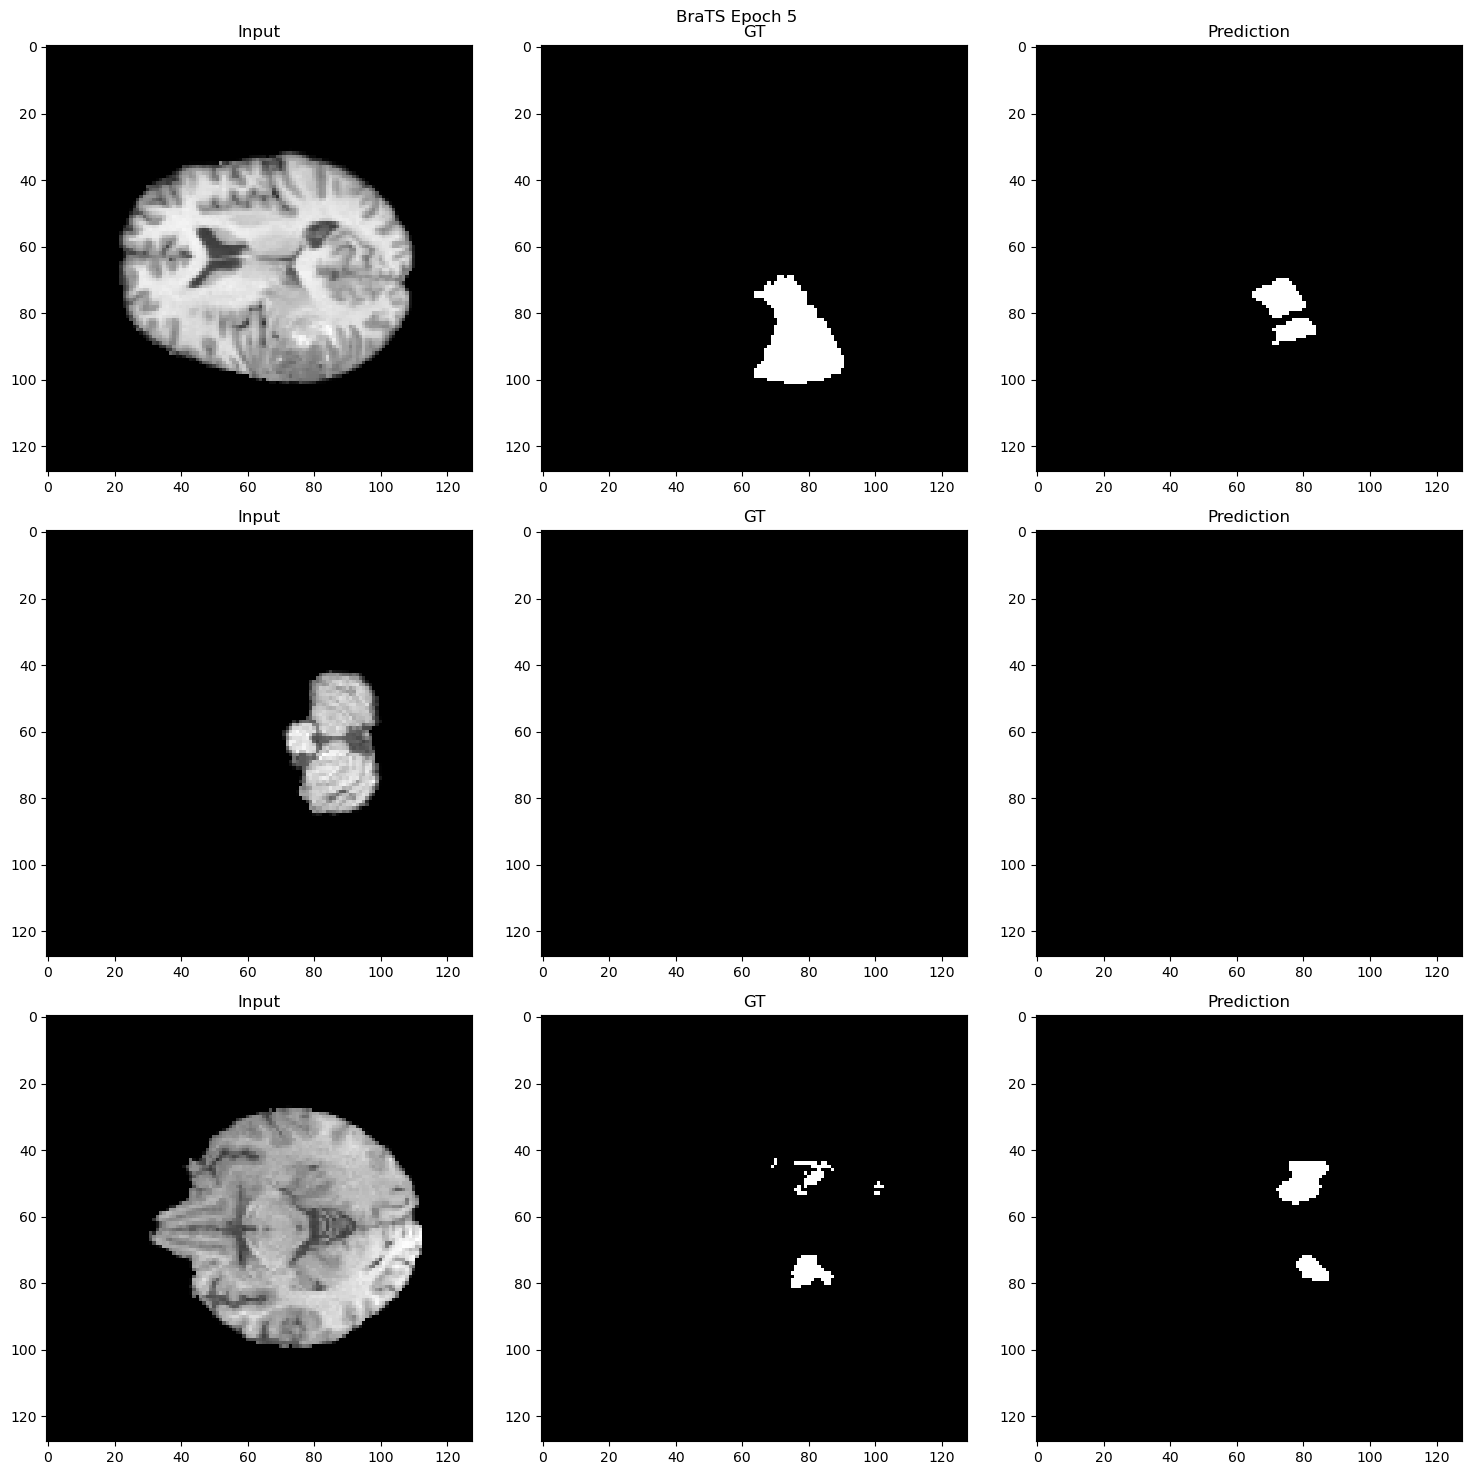

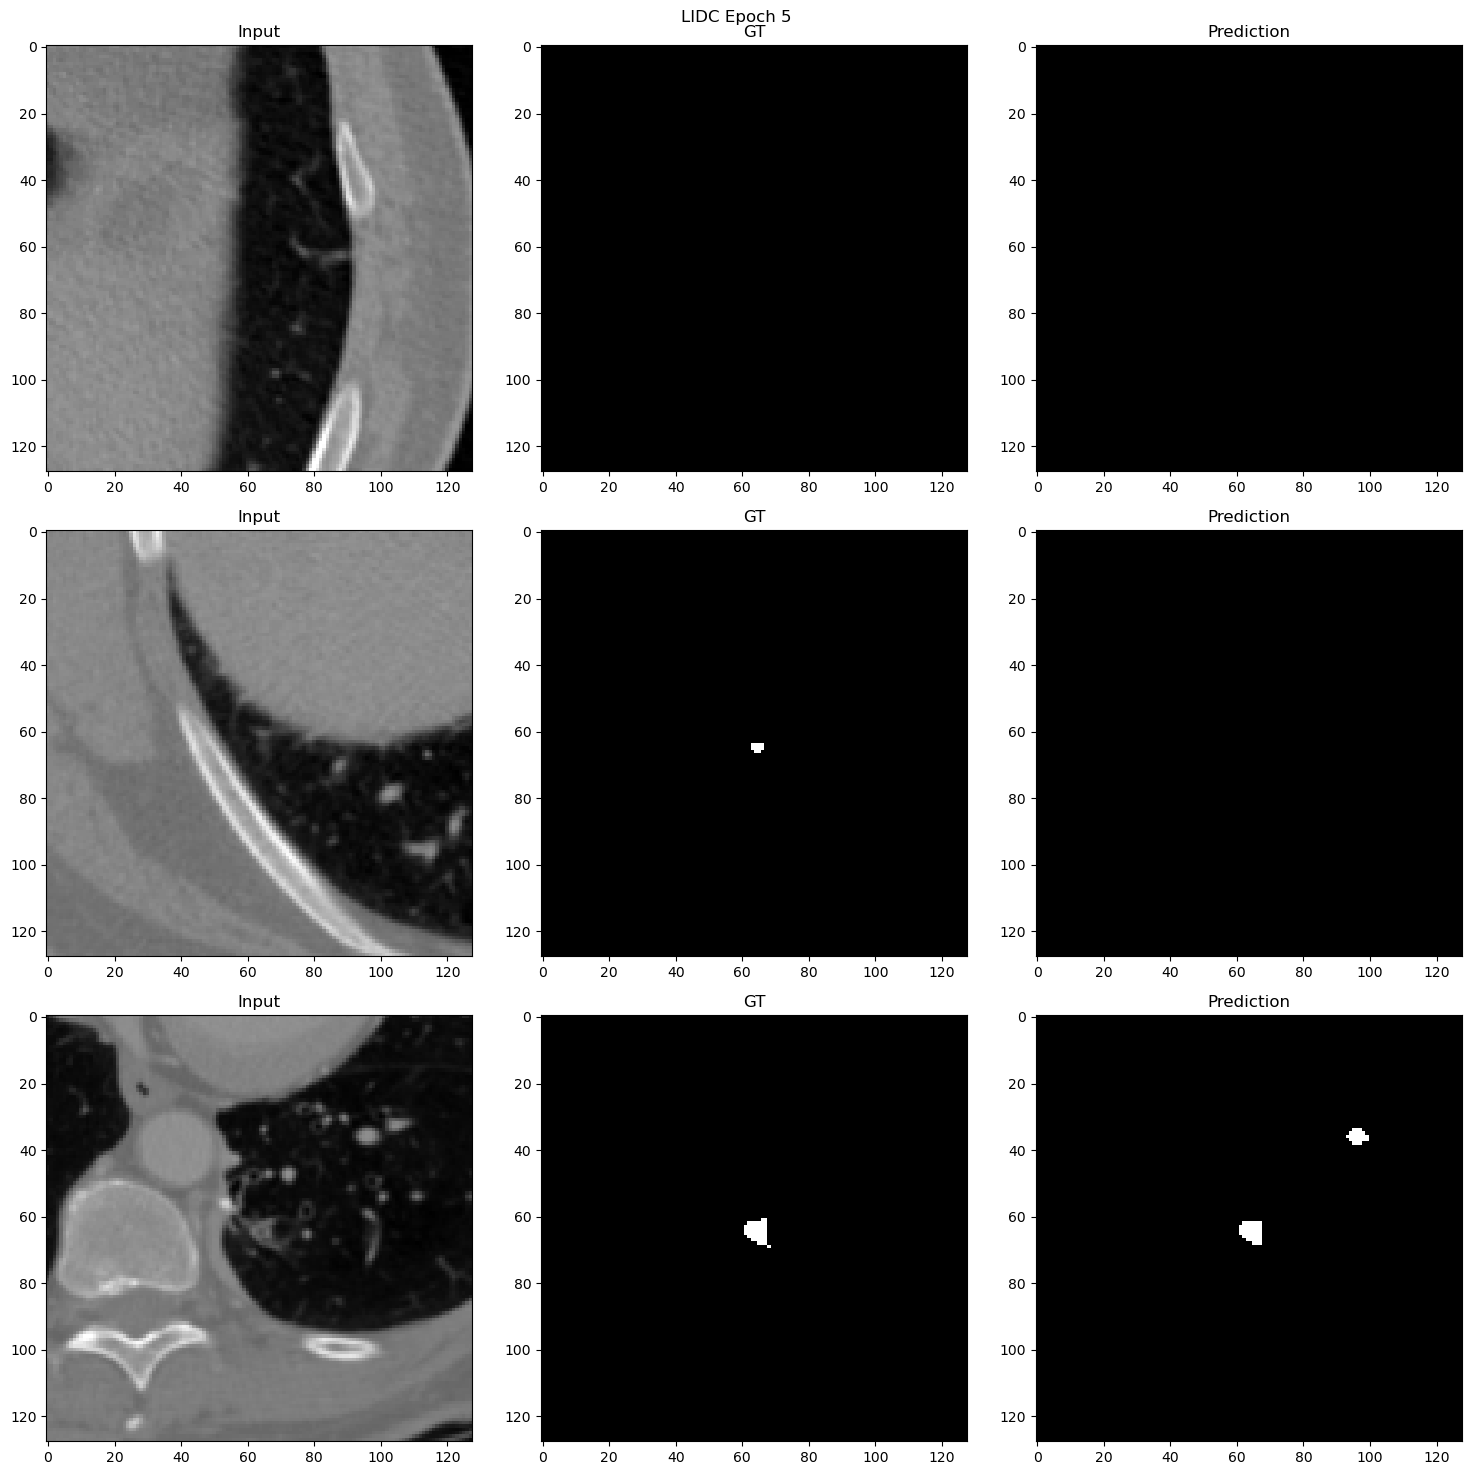

Epoch 6/45: 100%|██████████| 1365/1365 [05:22<00:00,  4.24it/s, dice=0.74, loss=0.276, lr=0.000131] 



Epoch 6/45
Train Loss: 0.4288 | Dice: 0.6326
BraTS Val Loss: 0.2832 | Dice: 0.7958
LIDC Val Loss: 0.4654 | Dice: 0.5365
No significant improvement. Patience: 1/3


Epoch 7/45: 100%|██████████| 1365/1365 [05:20<00:00,  4.26it/s, dice=0.532, loss=0.522, lr=0.000164] 



Epoch 7/45
Train Loss: 0.4208 | Dice: 0.6427
BraTS Val Loss: 0.3423 | Dice: 0.8439
LIDC Val Loss: 0.4821 | Dice: 0.5126
Saved new best model!


Epoch 8/45: 100%|██████████| 1365/1365 [05:21<00:00,  4.25it/s, dice=0.733, loss=0.602, lr=0.000197] 



Epoch 8/45
Train Loss: 0.4260 | Dice: 0.6486
BraTS Val Loss: 0.2864 | Dice: 0.8521
LIDC Val Loss: 0.5031 | Dice: 0.5041
No significant improvement. Patience: 1/3


Epoch 9/45: 100%|██████████| 1365/1365 [05:20<00:00,  4.26it/s, dice=0.723, loss=0.157, lr=0.000228]



Epoch 9/45
Train Loss: 0.4159 | Dice: 0.6444
BraTS Val Loss: 0.2986 | Dice: 0.8457
LIDC Val Loss: 0.4921 | Dice: 0.5047
No significant improvement. Patience: 2/3


Epoch 10/45: 100%|██████████| 1365/1365 [05:20<00:00,  4.27it/s, dice=0.638, loss=0.366, lr=0.000255]



Epoch 10/45
Train Loss: 0.4137 | Dice: 0.6508
BraTS Val Loss: 0.3082 | Dice: 0.8581
LIDC Val Loss: 0.4901 | Dice: 0.5102
Saved new best model!


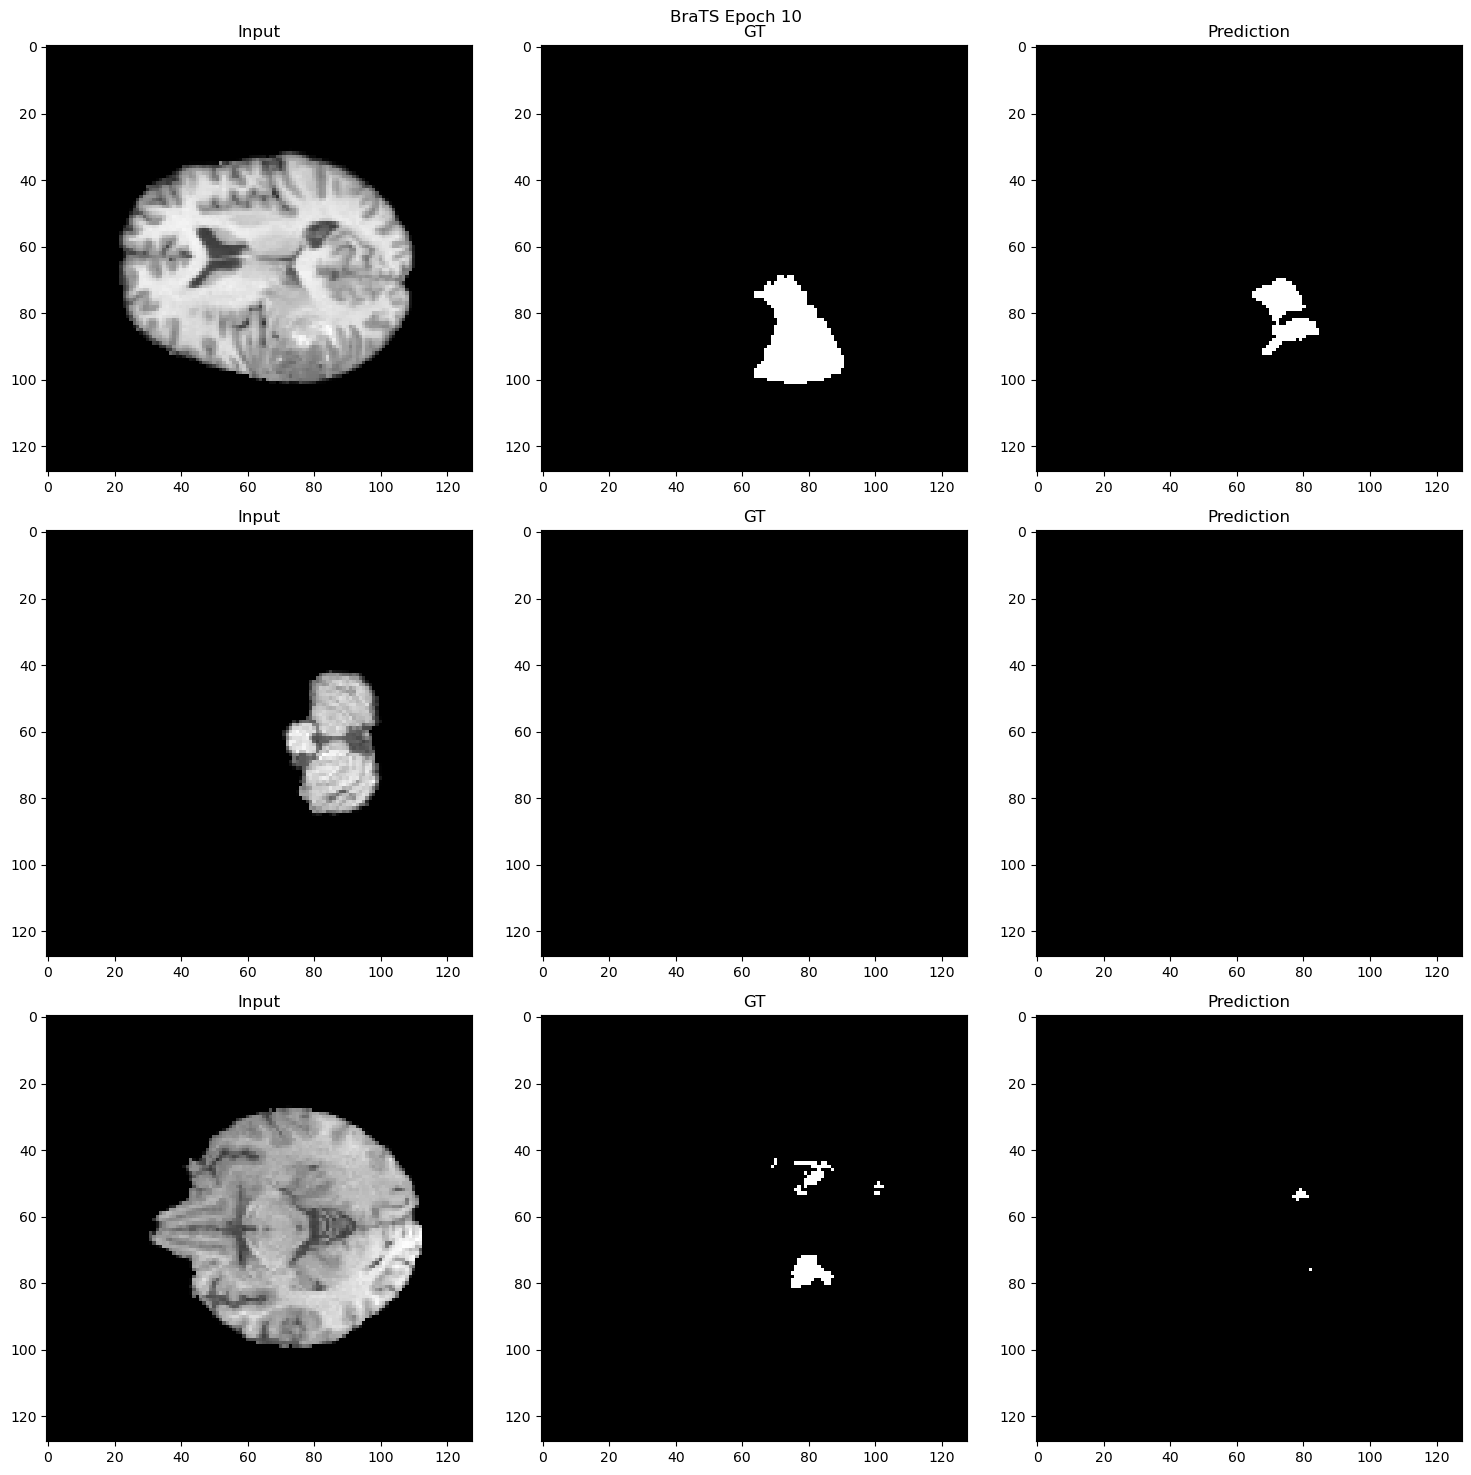

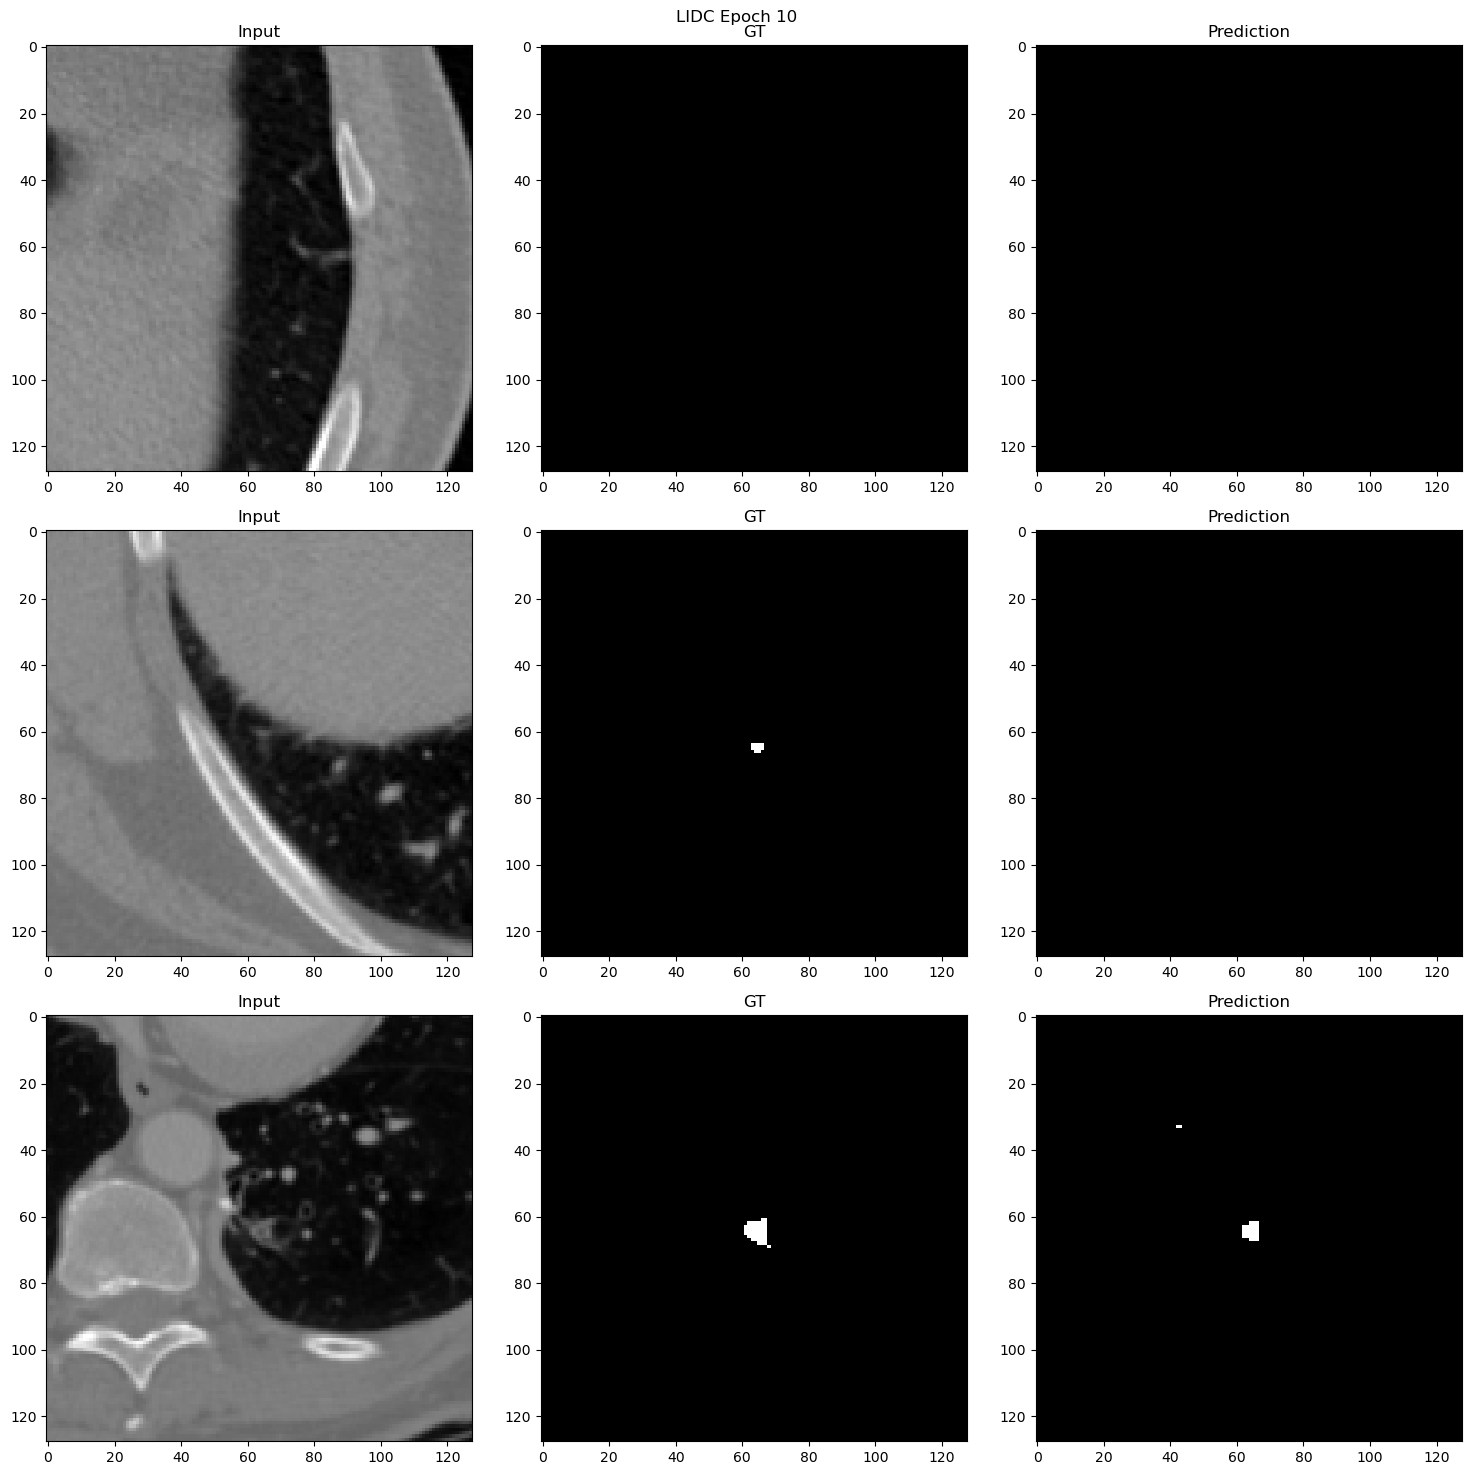

Epoch 11/45: 100%|██████████| 1365/1365 [05:18<00:00,  4.29it/s, dice=0.699, loss=0.142, lr=0.000276]



Epoch 11/45
Train Loss: 0.4119 | Dice: 0.6548
BraTS Val Loss: 0.2512 | Dice: 0.8183
LIDC Val Loss: 0.5359 | Dice: 0.5092
No significant improvement. Patience: 1/3


Epoch 12/45: 100%|██████████| 1365/1365 [05:20<00:00,  4.26it/s, dice=0.679, loss=0.579, lr=0.000291]



Epoch 12/45
Train Loss: 0.4031 | Dice: 0.6637
BraTS Val Loss: 0.3120 | Dice: 0.8480
LIDC Val Loss: 0.4689 | Dice: 0.5208
No significant improvement. Patience: 2/3


Epoch 13/45: 100%|██████████| 1365/1365 [05:19<00:00,  4.27it/s, dice=0.653, loss=0.325, lr=0.000299]



Epoch 13/45
Train Loss: 0.3922 | Dice: 0.6763
BraTS Val Loss: 0.2499 | Dice: 0.8528
LIDC Val Loss: 0.4612 | Dice: 0.5374
Saved new best model!


Epoch 14/45: 100%|██████████| 1365/1365 [05:18<00:00,  4.28it/s, dice=0.776, loss=0.168, lr=0.0003] 



Epoch 14/45
Train Loss: 0.3902 | Dice: 0.6773
BraTS Val Loss: 0.2543 | Dice: 0.8593
LIDC Val Loss: 0.5065 | Dice: 0.5130
No significant improvement. Patience: 1/3


Epoch 15/45: 100%|██████████| 1365/1365 [05:17<00:00,  4.30it/s, dice=0.832, loss=0.43, lr=0.000298] 



Epoch 15/45
Train Loss: 0.3824 | Dice: 0.6798
BraTS Val Loss: 0.2558 | Dice: 0.8566
LIDC Val Loss: 0.4658 | Dice: 0.5200
No significant improvement. Patience: 2/3


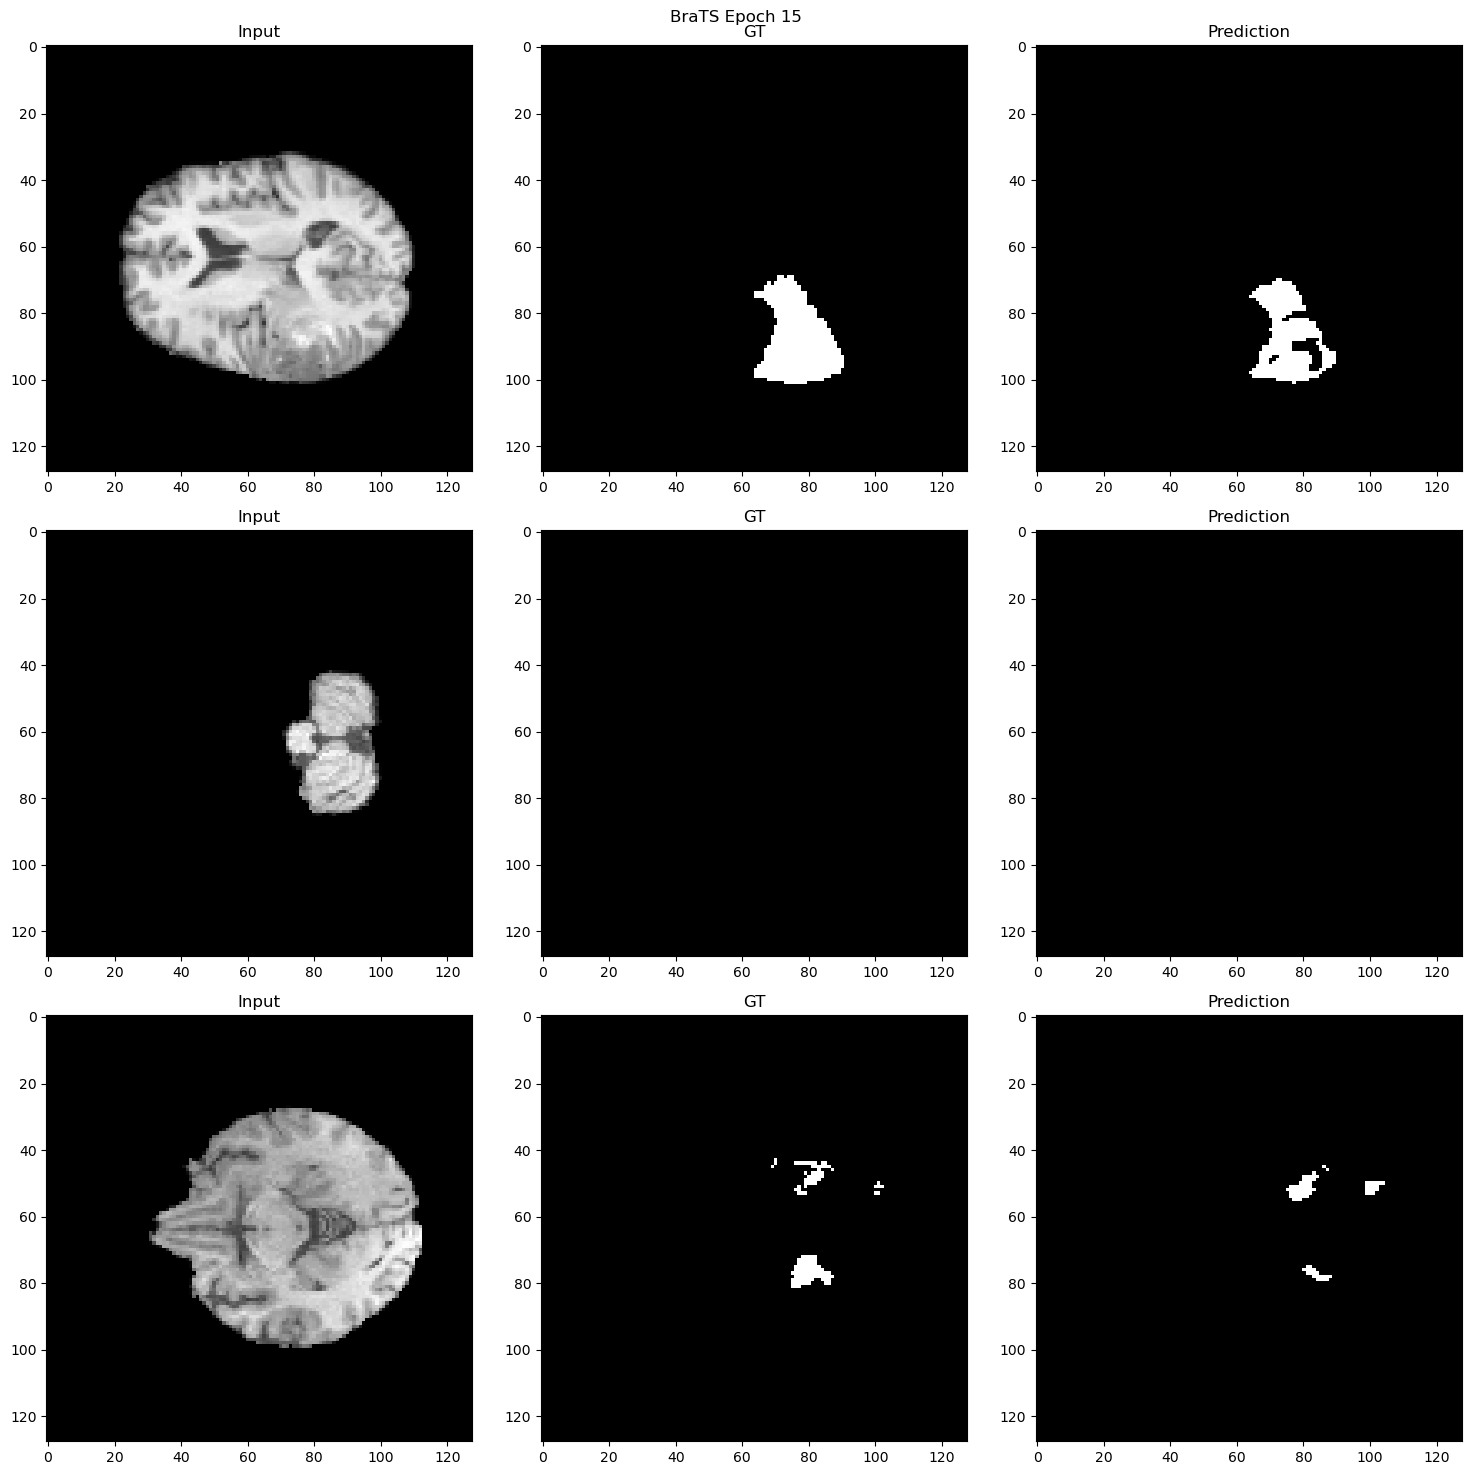

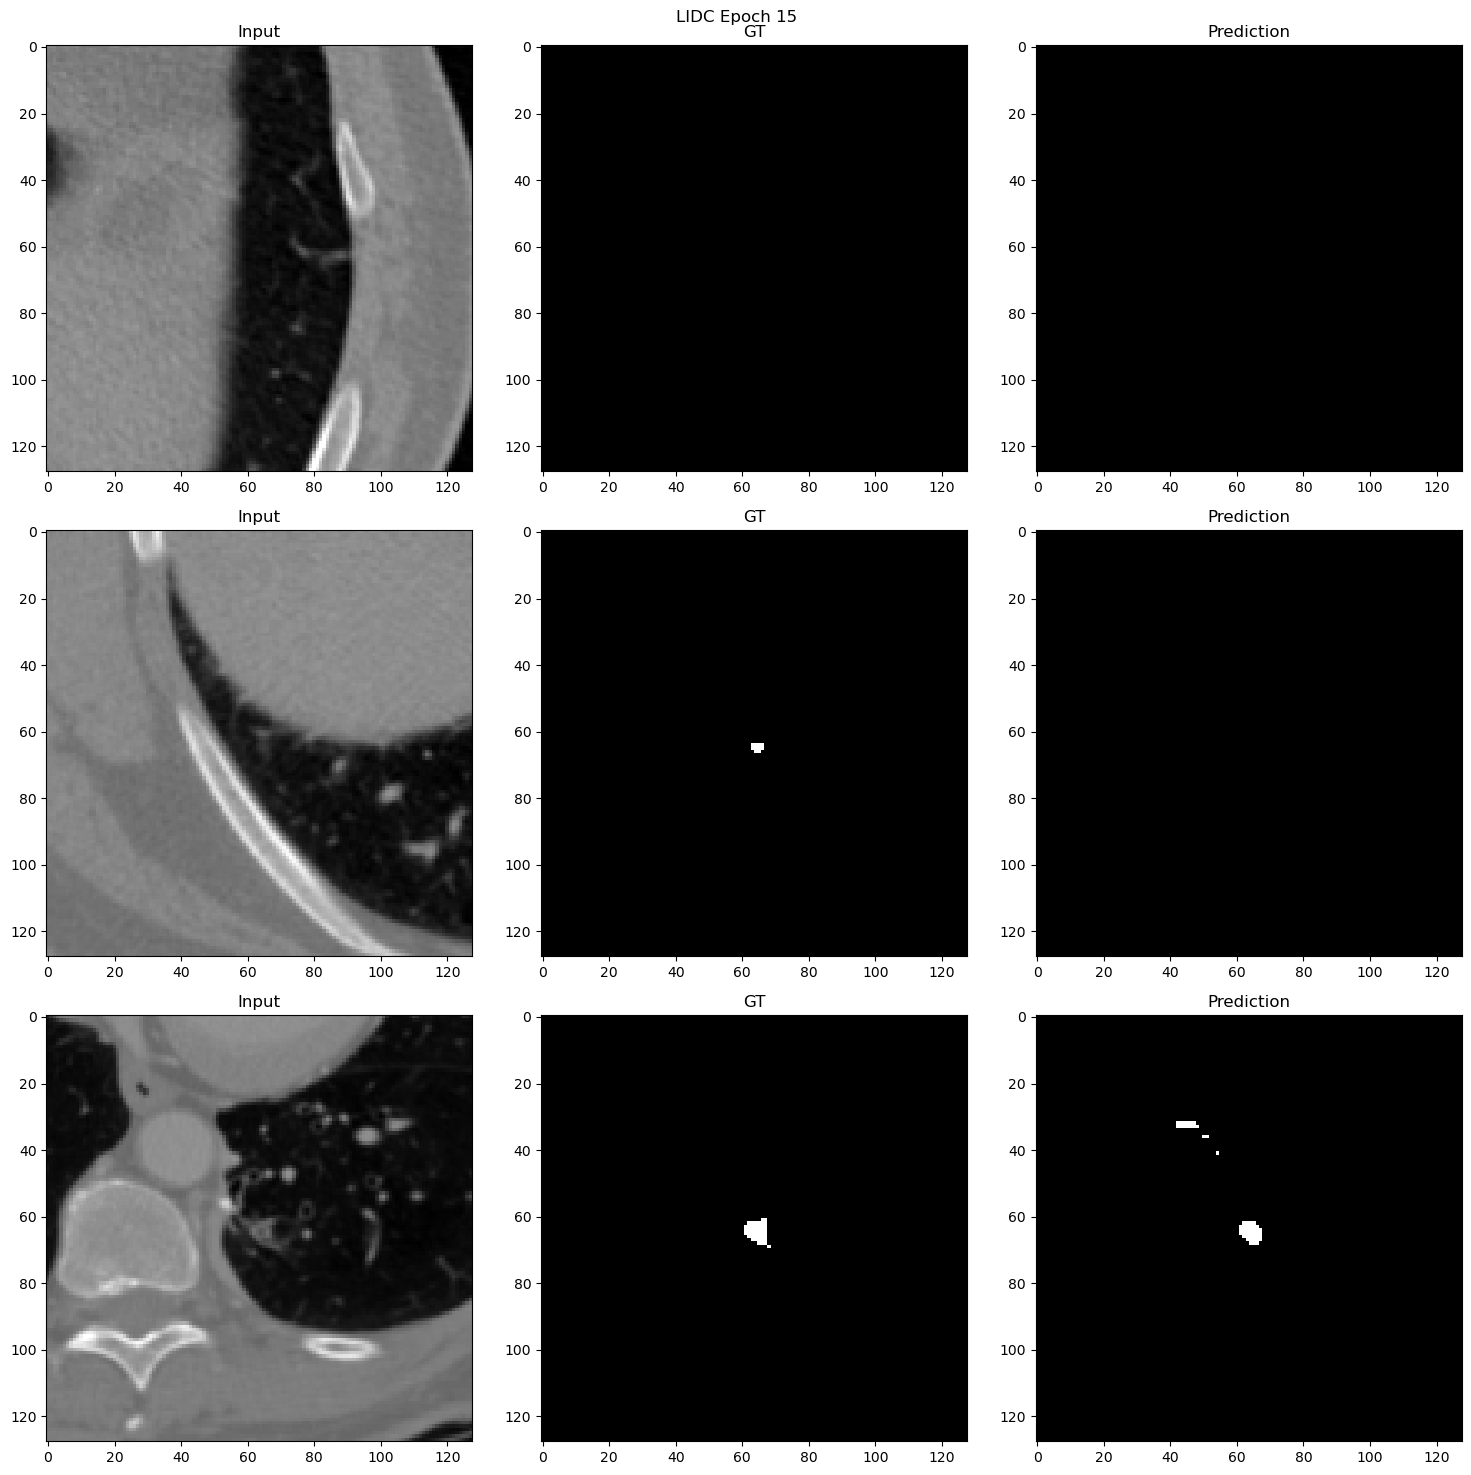

Epoch 16/45: 100%|██████████| 1365/1365 [05:22<00:00,  4.23it/s, dice=0.726, loss=0.449, lr=0.000295] 



Epoch 16/45
Train Loss: 0.3806 | Dice: 0.6869
BraTS Val Loss: 0.2300 | Dice: 0.8437
LIDC Val Loss: 0.4855 | Dice: 0.5412
No significant improvement. Patience: 3/3
Early stopping triggered!

Total Training Time: 106 minutes 12 seconds


In [ ]:
# Create combined dataset
combined_dataset = ConcatDataset([brats_train, lidc_train])

# Create loaders with custom collate
def collate_fn(batch):
    x = torch.stack([item[0] for item in batch])
    y = torch.stack([item[1] for item in batch])
    return x, y

train_loader = DataLoader(
    combined_dataset,
    batch_sampler=BalancedSampler(brats_train, lidc_train, batch_size=8),
    collate_fn=collate_fn,
    num_workers=4
)

# Validation loaders
val_brats_loader = DataLoader(brats_val, batch_size=8, collate_fn=collate_fn)
val_lidc_loader = DataLoader(lidc_val, batch_size=8, collate_fn=collate_fn)
# LIDC Pretraining
model_pre = AttentionUNet(in_channels=4, out_channels=1).to(device)
optimizer = torch.optim.Adam(model_pre.parameters(), lr=1e-4)
lidc_criterion = FocalTverskyLoss(alpha=0.5, beta=0.5)

print("Starting LIDC pretraining...")
for epoch in range(5):  # You can increase to 10 if needed
    model_pre.train()
    total_loss = 0
    for x, y in train_loader_lidc:
        x, y = x.to(device), y.to(device)
        preds = model_pre(x)
        loss = lidc_criterion(preds, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"LIDC Pretrain Epoch {epoch+1} | Avg Loss: {total_loss / len(train_loader_lidc):.4f}")

# Save pretraining weights
torch.save(model_pre.state_dict(), "lidc_pretrained.pth")
print("LIDC pretraining complete and saved.")

# Load and Continue Unified Training 
modelV2 = AttentionUNet(in_channels=4, out_channels=1).to(device)
modelV2.load_state_dict(torch.load("lidc_pretrained.pth"))

# Now run full joint training
hist = unified_train_model(
    modelV2,
    train_loader=train_loader,
    val_loaders=(val_loader_brats, val_loader_lidc),
    num_epochs=45,
    lr=1e-4
)


### Evaluation accros datasets

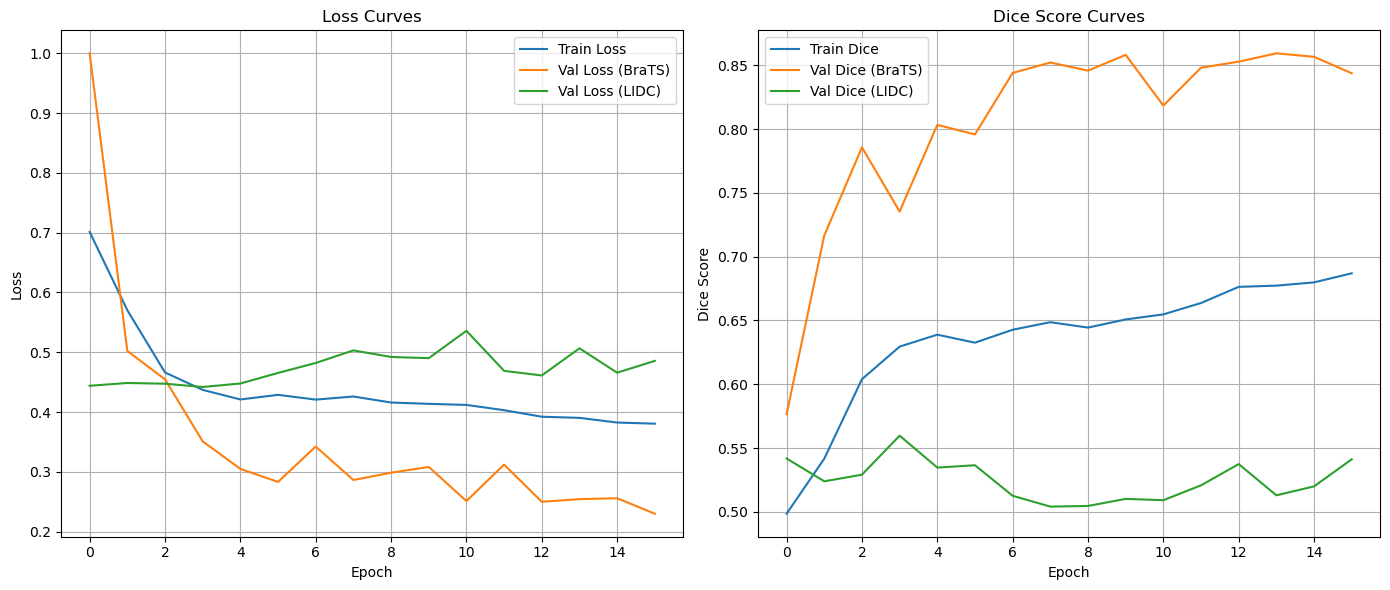

In [60]:
import matplotlib.pyplot as plt

# Extract validation losses and dice scores from the tuples
val_loss_brats = [v[0] for v in hist["val_brats"]]
val_dice_brats = [v[1] for v in hist["val_brats"]]
val_loss_lidc  = [v[0] for v in hist["val_lidc"]]
val_dice_lidc  = [v[1] for v in hist["val_lidc"]]

plt.figure(figsize=(14, 6))

# Loss Curves
plt.subplot(1, 2, 1)
plt.plot(hist["train_loss"], label="Train Loss")
plt.plot(val_loss_brats, label="Val Loss (BraTS)")
plt.plot(val_loss_lidc, label="Val Loss (LIDC)")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss Curves")
plt.legend()
plt.grid(True)

# Dice Score Curves
plt.subplot(1, 2, 2)
plt.plot(hist["train_dice"], label="Train Dice")
plt.plot(val_dice_brats, label="Val Dice (BraTS)")
plt.plot(val_dice_lidc, label="Val Dice (LIDC)")
plt.xlabel("Epoch")
plt.ylabel("Dice Score")
plt.title("Dice Score Curves")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


Evaluating on BraTS and LIDC...


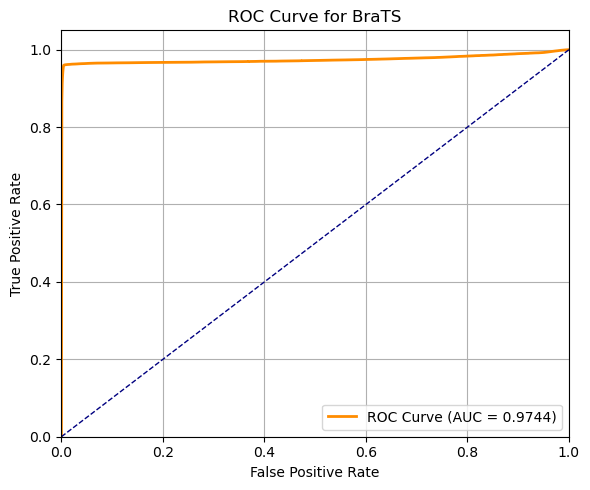


BraTS Evaluation:
Samples with tumor: 517 / 1170
Dice:           0.8326
IoU:            0.7962
Precision:      0.8600
Recall:         0.9220
F1-Score:       0.8378
Tversky Index:  0.8431
Hausdorff (95): 31.4944
ROC AUC:        0.9744
Patient-level detection rate: 0.3957

Confusion Matrix (Cumulative):
TP: 206520, FP: 54601, FN: 12367, TN: 18895792


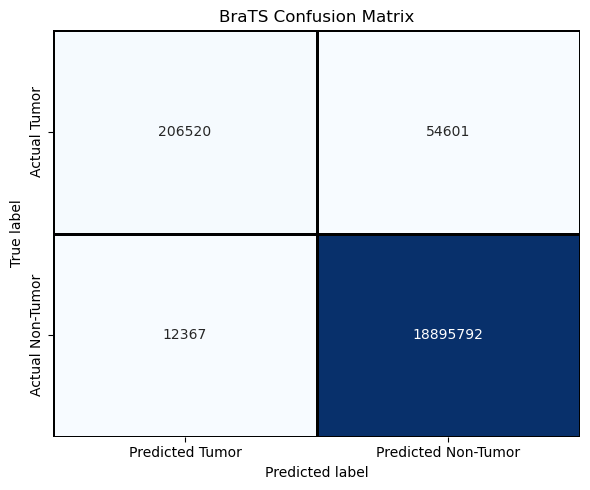

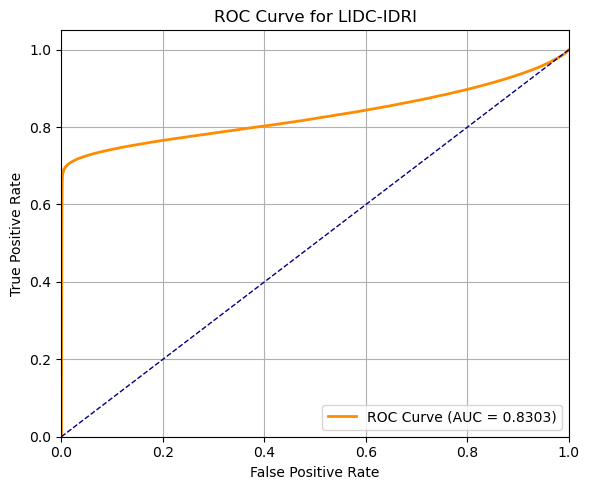


LIDC-IDRI Evaluation:
Samples with tumor: 1620 / 2333
Dice:           0.5471
IoU:            0.4907
Precision:      0.7375
Recall:         0.6911
F1-Score:       0.5727
Tversky Index:  0.5479
Hausdorff (95): 45.6070
ROC AUC:        0.8303
Patient-level detection rate: 0.5195

Confusion Matrix (Cumulative):
TP: 136034, FP: 45843, FN: 92101, TN: 37949894


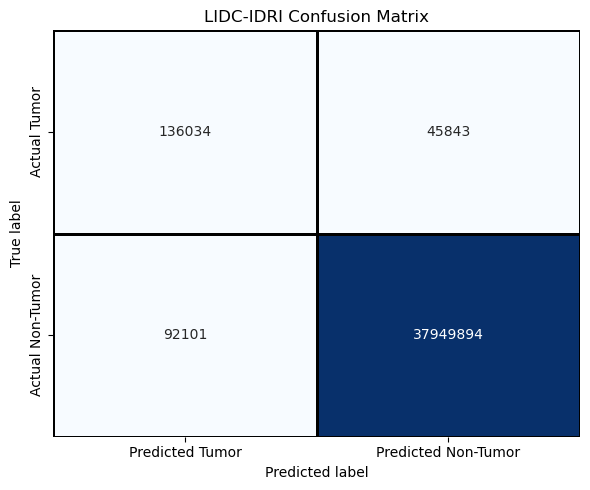

In [ ]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import torch
from sklearn.metrics import roc_auc_score, roc_curve, auc
from scipy.spatial.distance import directed_hausdorff

def hausdorff_distance(pred, target):
    pred_coords = torch.nonzero(pred).cpu().numpy()
    target_coords = torch.nonzero(target).cpu().numpy()
    if len(pred_coords) == 0 or len(target_coords) == 0:
        return np.nan
    hd1 = directed_hausdorff(pred_coords, target_coords)[0]
    hd2 = directed_hausdorff(target_coords, pred_coords)[0]
    return max(hd1, hd2)

def tversky_index(p, t, alpha=0.7, beta=0.3, smooth=1e-6):
    tp = (p * t).sum().item()
    fn = ((1 - p) * t).sum().item()
    fp = (p * (1 - t)).sum().item()
    return (tp + smooth) / (tp + alpha * fn + beta * fp + smooth)

def plot_confusion_matrix(tp, fp, fn, tn, name="", labels=["Tumor", "Non-Tumor"]):
    cm = np.array([[tp, fp],
                   [fn, tn]])
    df_cm = pd.DataFrame(cm, index=[f"Actual {l}" for l in labels],
                            columns=[f"Predicted {l}" for l in labels])
    
    plt.figure(figsize=(6, 5))
    sns.heatmap(df_cm, annot=True, fmt='d', cmap='Blues', cbar=False, linewidths=1, linecolor='black')
    plt.title(f"{name} Confusion Matrix")
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.show()

def evaluate_model(model, loader, name="", threshold=0.1):
    model.eval()
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    dice_all, iou_all, precision_all, recall_all, f1_all = [], [], [], [], []
    tversky_all, hd95_all, auc_all, patient_hit_flags = [], [], [], []
    all_targets, all_probs = [], []
    TP, FP, FN, TN = 0, 0, 0, 0
    total_samples = 0
    non_empty_samples = 0

    with torch.no_grad():
        for x, y in loader:
            x, y = x.to(device), y.to(device).float()
            y_bin = (y > 0.5).float()
            probs = torch.sigmoid(model(x))
            preds = (probs > threshold).float()

            total_samples += x.size(0)
            non_empty_samples += (y_bin.sum(dim=(1, 2, 3)) > 0).sum().item()

            for i in range(x.size(0)):
                p = preds[i].view(-1)
                t = y_bin[i].view(-1)
                prob_flat = probs[i].view(-1).cpu().numpy()
                target_flat = t.cpu().numpy()

                tp = (p * t).sum().item()
                fp = ((p == 1) & (t == 0)).sum().item()
                fn = ((p == 0) & (t == 1)).sum().item()
                tn = ((p == 0) & (t == 0)).sum().item()

                TP += tp
                FP += fp
                FN += fn
                TN += tn

                precision = (tp + 1e-7) / (tp + fp + 1e-7)
                recall = (tp + 1e-7) / (tp + fn + 1e-7)
                f1 = (2 * precision * recall + 1e-7) / (precision + recall + 1e-7)
                iou = (tp + 1e-7) / (tp + fp + fn + 1e-7)
                dice = (2 * tp + 1e-7) / (p.sum().item() + t.sum().item() + 1e-7)
                tversky = tversky_index(p, t)
                hd = hausdorff_distance(preds[i, 0], y_bin[i, 0])

                try:
                    auc_val = roc_auc_score(target_flat, prob_flat)
                except:
                    auc_val = np.nan

                dice_all.append(dice)
                iou_all.append(iou)
                precision_all.append(precision)
                recall_all.append(recall)
                f1_all.append(f1)
                tversky_all.append(tversky)
                hd95_all.append(hd)
                auc_all.append(auc_val)
                patient_hit_flags.append(1 if tp > 0 else 0)

                all_targets.extend(target_flat)
                all_probs.extend(prob_flat)

    # ROC Plot
    try:
        fpr, tpr, _ = roc_curve(all_targets, all_probs)
        roc_auc = auc(fpr, tpr)
        plt.figure(figsize=(6, 5))
        plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC Curve (AUC = {roc_auc:.4f})')
        plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(f'ROC Curve for {name}')
        plt.legend(loc='lower right')
        plt.grid(True)
        plt.tight_layout()
        plt.show()
    except:
        roc_auc = np.nan

    # Summary Print 
    print(f"\n{name} Evaluation:")
    print(f"Samples with tumor: {non_empty_samples} / {total_samples}")
    print(f"Dice:           {np.nanmean(dice_all):.4f}")
    print(f"IoU:            {np.nanmean(iou_all):.4f}")
    print(f"Precision:      {np.nanmean(precision_all):.4f}")
    print(f"Recall:         {np.nanmean(recall_all):.4f}")
    print(f"F1-Score:       {np.nanmean(f1_all):.4f}")
    print(f"Tversky Index:  {np.nanmean(tversky_all):.4f}")
    print(f"Hausdorff (95): {np.nanpercentile([h for h in hd95_all if not np.isnan(h)], 95):.4f}")
    print(f"ROC AUC:        {roc_auc:.4f}")
    print(f"Patient-level detection rate: {np.mean(patient_hit_flags):.4f}")
    print("\nConfusion Matrix (Cumulative):")
    print(f"TP: {int(TP)}, FP: {int(FP)}, FN: {int(FN)}, TN: {int(TN)}")

    # Confusion Matrix Plot 
    plot_confusion_matrix(int(TP), int(FP), int(FN), int(TN), name=name)

# Evaluate on BraTS and LIDC
print("Evaluating on BraTS and LIDC...")
evaluate_model(modelV2, test_loader_brats, name="BraTS", threshold=0.1)
evaluate_model(modelV2, test_loader_lidc, name="LIDC-IDRI", threshold=0.1)


Evaluating on Unified Test Set


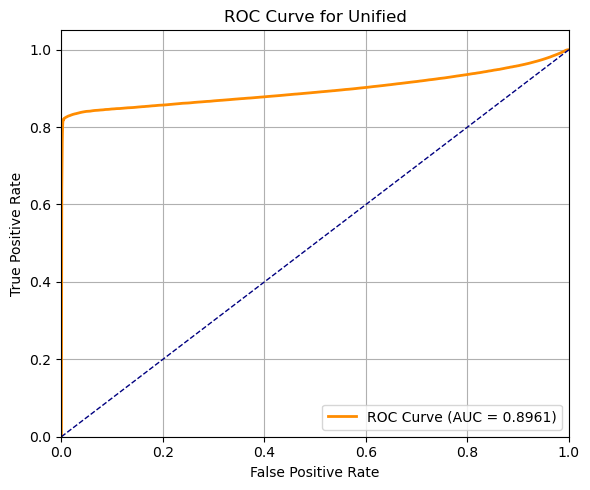


Unified Evaluation:
Samples with tumor: 2137 / 3503
Dice:           0.6424
IoU:            0.5928
Precision:      0.7784
Recall:         0.7682
F1-Score:       0.6612
Tversky Index:  0.6465
Hausdorff (95): 43.3907
ROC AUC:        0.8961
Patient-level detection rate: 0.4782

Confusion Matrix (Cumulative):
TP: 342554, FP: 100444, FN: 104468, TN: 56845686


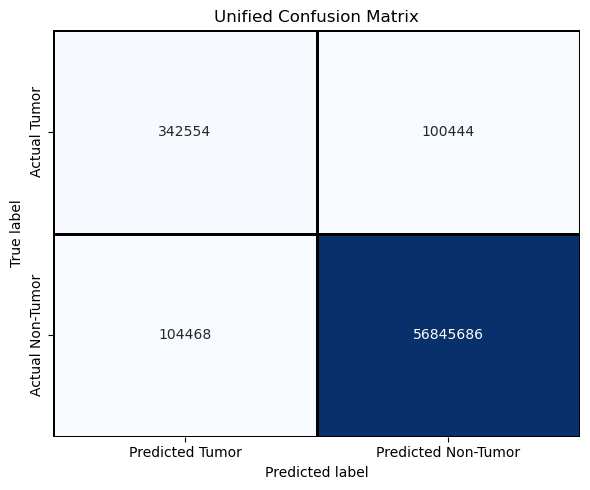

In [72]:
combined_test_dataset = ConcatDataset([brats_test, lidc_test])
combined_test_loader = DataLoader(combined_test_dataset, batch_size=8, shuffle=False)

# === Evaluate on Unified Test Set ===
print("Evaluating on Unified Test Set")
evaluate_model(modelV2, combined_test_loader, name="Unified", threshold=0.1)


### Visualize prediction

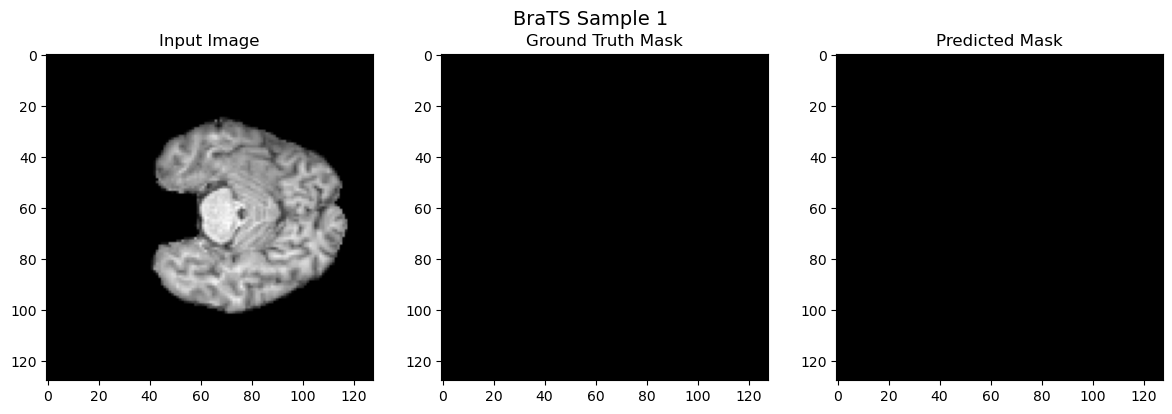

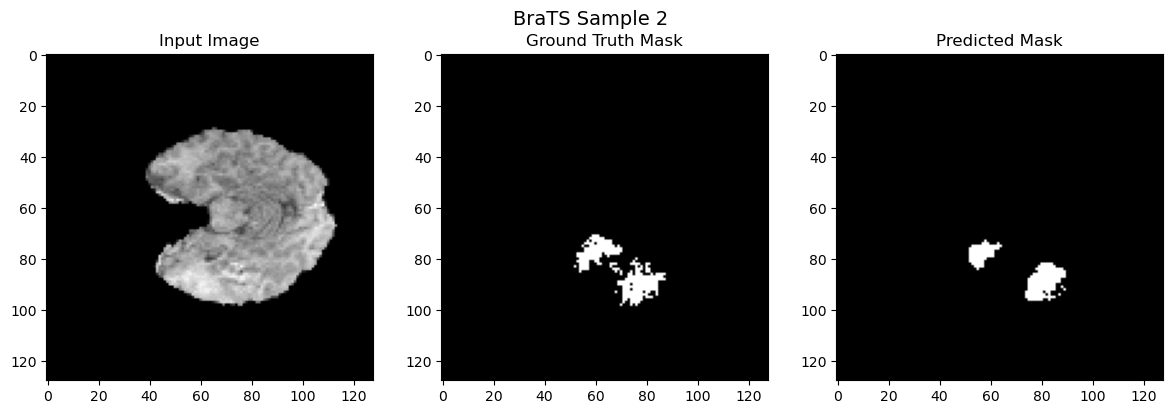

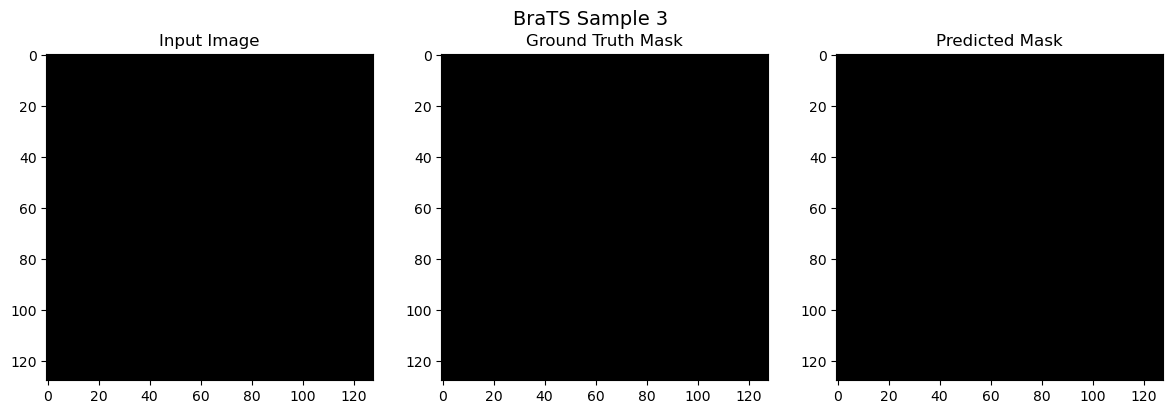

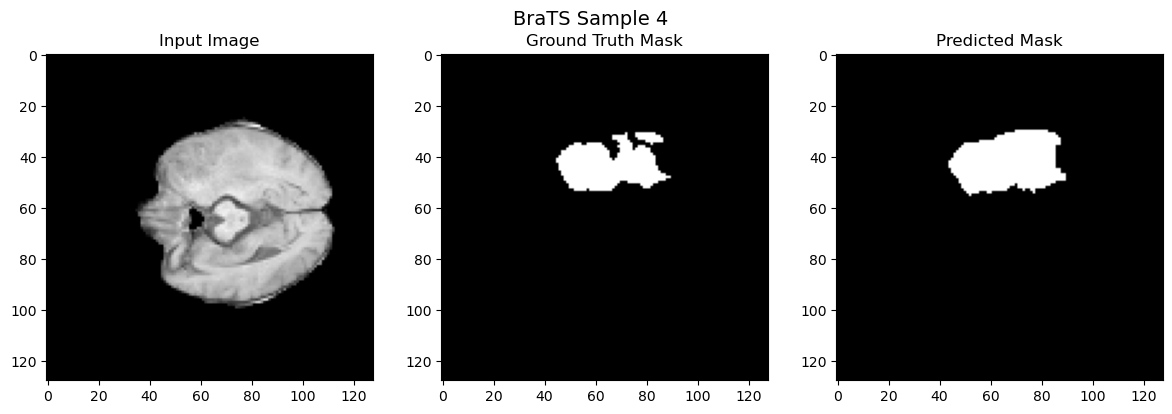

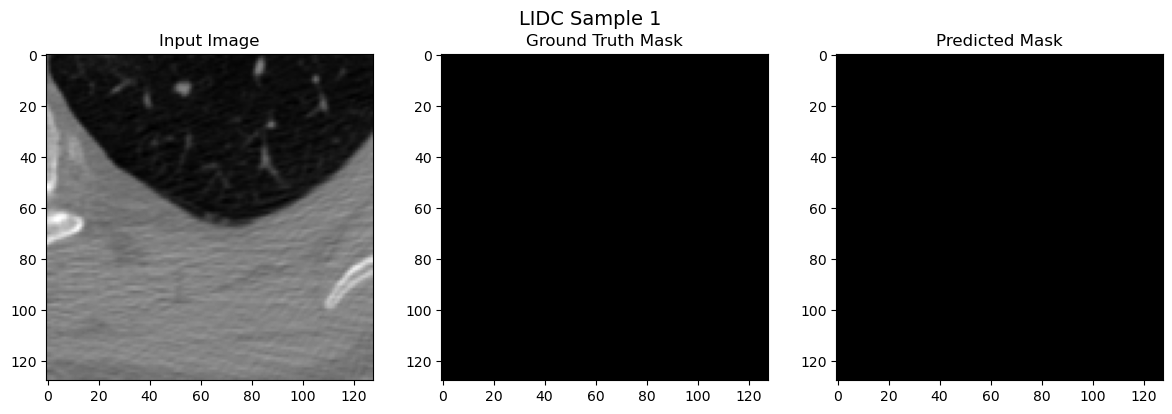

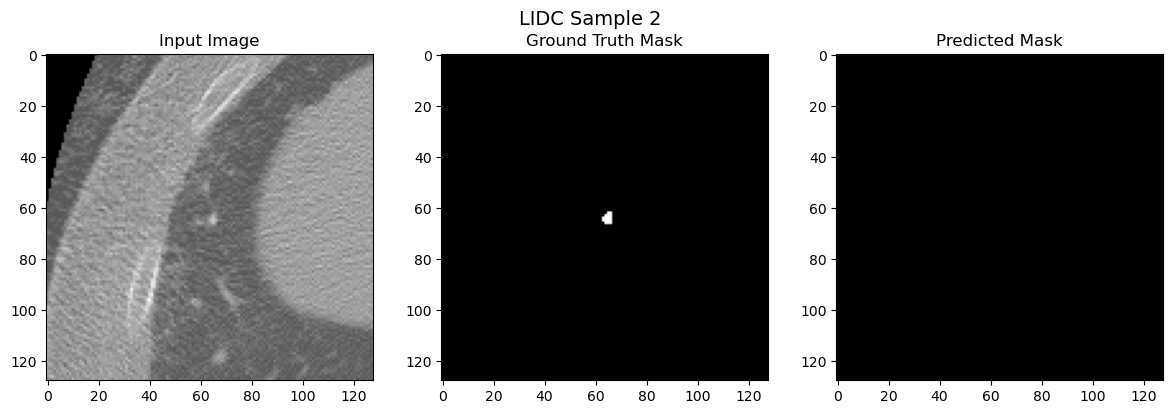

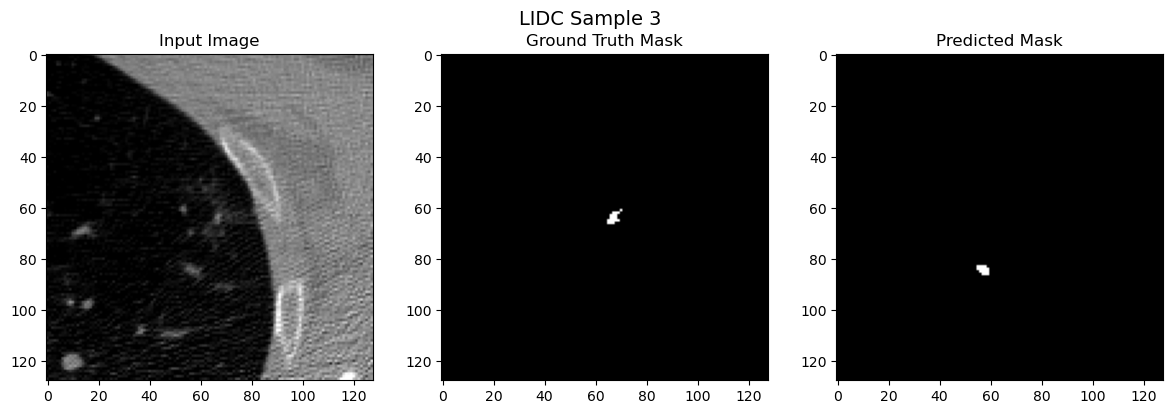

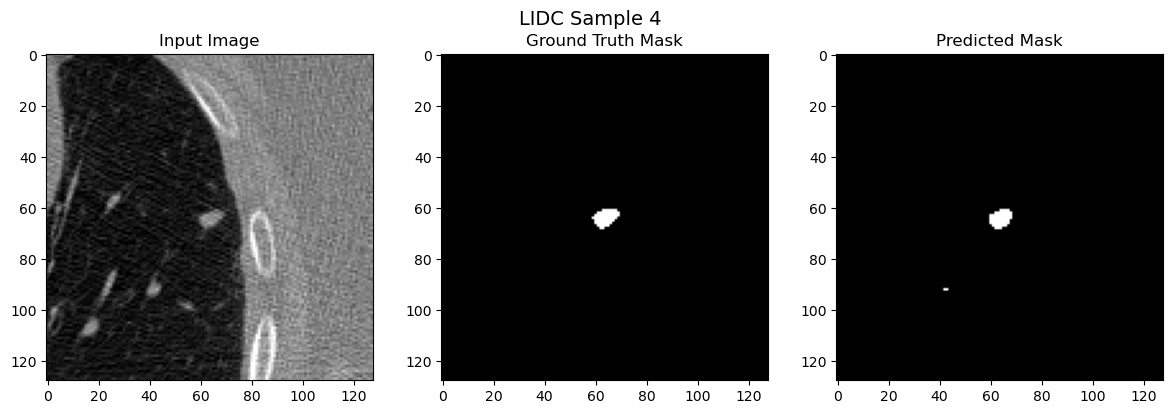

In [ ]:
import matplotlib.pyplot as plt
import torch

def visualize_predictions_dual(model, loader1, loader2, name1="BraTS", name2="LIDC", num_samples=4):
    """
    Visualizes `num_samples` predictions from each of two datasets (e.g., BraTS and LIDC).

    Args:
        model (torch.nn.Module): Trained segmentation model.
        loader1, loader2: DataLoaders for two datasets.
        name1, name2: Labels for dataset names.
        num_samples (int): Number of samples to show per dataset.
    """
    model.eval()
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    shown = {name1: 0, name2: 0}

    def show_batch(x, y, preds, dataset_name):
        for i in range(x.size(0)):
            if shown[dataset_name] >= num_samples:
                break

            plt.figure(figsize=(12, 4))
            plt.suptitle(f"{dataset_name} Sample {shown[dataset_name]+1}", fontsize=14)

            plt.subplot(1, 3, 1)
            plt.imshow(x[i, 0].cpu(), cmap='gray')
            plt.title("Input Image")

            plt.subplot(1, 3, 2)
            plt.imshow(y[i, 0], cmap='gray')
            plt.title("Ground Truth Mask")

            plt.subplot(1, 3, 3)
            plt.imshow(preds[i, 0], cmap='gray')
            plt.title("Predicted Mask")

            plt.tight_layout()
            plt.show()
            shown[dataset_name] += 1

    with torch.no_grad():
        # BraTS visualization
        for x, y in loader1:
            x = x.to(device)
            y_np = y.cpu().numpy()
            preds = (torch.sigmoid(model(x)) > 0.5).cpu().numpy()
            show_batch(x, y_np, preds, name1)
            if shown[name1] >= num_samples:
                break

        # LIDC visualization
        for x, y in loader2:
            x = x.to(device)
            y_np = y.cpu().numpy()
            preds = (torch.sigmoid(model(x)) > 0.5).cpu().numpy()
            show_batch(x, y_np, preds, name2)
            if shown[name2] >= num_samples:
                break

visualize_predictions_dual(modelV2, test_loader_brats, test_loader_lidc)


In [64]:
! pip install torchinfo

In [65]:
from torchinfo import summary

model_T = AttentionUNet(in_channels=4, out_channels=1).to("cuda")
summary(model_T, input_size=(1, 4, 128, 128))  # Batch size 1


Layer (type:depth-idx)                   Output Shape              Param #
AttentionUNet                            [1, 1, 128, 128]          --
├─DoubleConv: 1-1                        [1, 64, 128, 128]         --
│    └─Sequential: 2-1                   [1, 64, 128, 128]         --
│    │    └─Conv2d: 3-1                  [1, 64, 128, 128]         2,304
│    │    └─BatchNorm2d: 3-2             [1, 64, 128, 128]         128
│    │    └─LeakyReLU: 3-3               [1, 64, 128, 128]         --
│    │    └─Conv2d: 3-4                  [1, 64, 128, 128]         36,864
│    │    └─BatchNorm2d: 3-5             [1, 64, 128, 128]         128
│    │    └─LeakyReLU: 3-6               [1, 64, 128, 128]         --
├─MaxPool2d: 1-2                         [1, 64, 64, 64]           --
├─DoubleConv: 1-3                        [1, 128, 64, 64]          --
│    └─Sequential: 2-2                   [1, 128, 64, 64]          --
│    │    └─Conv2d: 3-7                  [1, 128, 64, 64]          73,728
│ 

In [66]:
# Print model summary
print(model_T)

AttentionUNet(
  (encoder1): DoubleConv(
    (block): Sequential(
      (0): Conv2d(4, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.01, inplace=True)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): LeakyReLU(negative_slope=0.01, inplace=True)
    )
  )
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (encoder2): DoubleConv(
    (block): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.01, inplace=True)
      (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1),

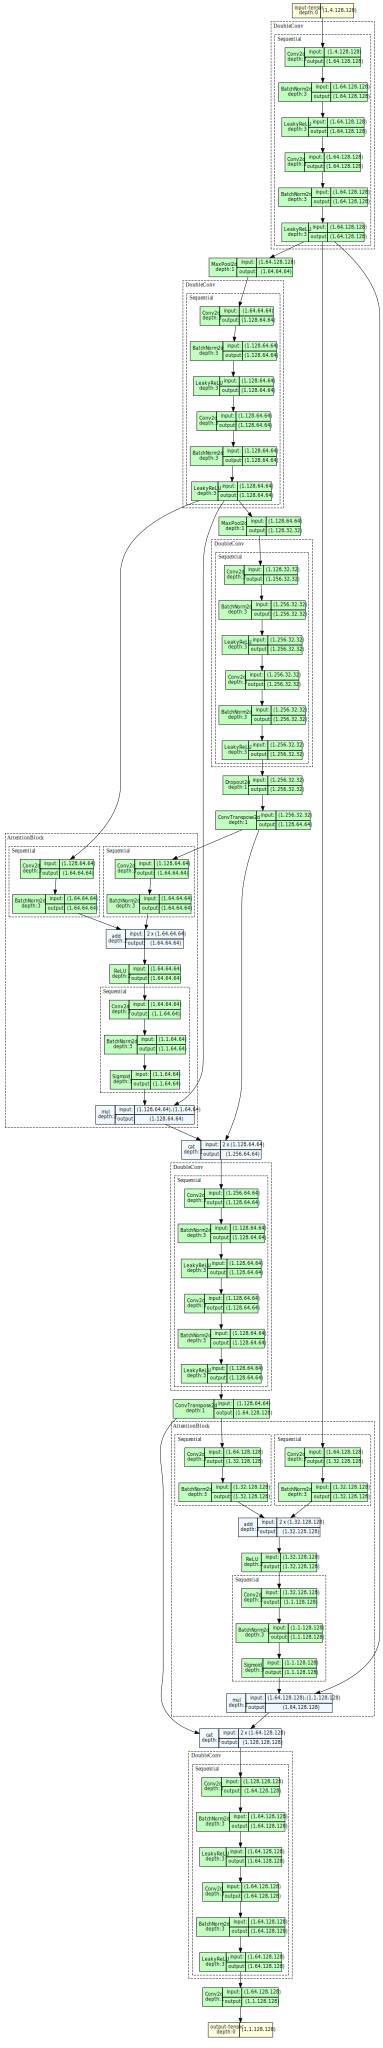

In [75]:
from torchview import draw_graph

# Create a dummy model
model_view = AttentionUNet(in_channels=4, out_channels=1).to("cuda")

# Draw architecture
model_graph = draw_graph(model_view, input_size=(1, 4, 128, 128), expand_nested=True)
model_graph.visual_graph.render("attention_unet", format="png")  # saves as PNG

model_graph.visual_graph  # Display in notebook


In [ ]:
import streamlit as st
import torch
import torch.nn as nn
import numpy as np
import os
from PIL import Image
import nibabel as nib
import matplotlib.pyplot as plt

class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.block = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, 3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(inplace=True)
        )

    def forward(self, x):
        return self.block(x)

class AttentionBlock(nn.Module):
    def __init__(self, F_g, F_l, F_int):
        super().__init__()
        self.W_g = nn.Sequential(nn.Conv2d(F_g, F_int, 1), nn.BatchNorm2d(F_int))
        self.W_x = nn.Sequential(nn.Conv2d(F_l, F_int, 1), nn.BatchNorm2d(F_int))
        self.psi = nn.Sequential(nn.Conv2d(F_int, 1, 1), nn.BatchNorm2d(1), nn.Sigmoid())
        self.relu = nn.ReLU(inplace=True)

    def forward(self, g, x):
        psi = self.relu(self.W_g(g) + self.W_x(x))
        return x * self.psi(psi)

class AttentionUNet(nn.Module):
    def __init__(self, in_channels=4, out_channels=1):
        super().__init__()
        features = [64, 128, 256]
        self.encoder1 = DoubleConv(in_channels, features[0])
        self.pool1 = nn.MaxPool2d(2)
        self.encoder2 = DoubleConv(features[0], features[1])
        self.pool2 = nn.MaxPool2d(2)
        self.bottleneck = DoubleConv(features[1], features[2])
        self.up2 = nn.ConvTranspose2d(features[2], features[1], 2, stride=2)
        self.att2 = AttentionBlock(features[1], features[1], features[1] // 2)
        self.decoder2 = DoubleConv(features[2], features[1])
        self.up1 = nn.ConvTranspose2d(features[1], features[0], 2, stride=2)
        self.att1 = AttentionBlock(features[0], features[0], features[0] // 2)
        self.decoder1 = DoubleConv(features[1], features[0])
        self.final_conv = nn.Conv2d(features[0], out_channels, 1)

    def forward(self, x):
        e1 = self.encoder1(x)
        e2 = self.encoder2(self.pool1(e1))
        b = self.bottleneck(self.pool2(e2))
        d2 = self.up2(b)
        a2 = self.att2(d2, e2)
        d2 = self.decoder2(torch.cat([d2, a2], dim=1))
        d1 = self.up1(d2)
        a1 = self.att1(d1, e1)
        d1 = self.decoder1(torch.cat([d1, a1], dim=1))
        return self.final_conv(d1)

@st.cache_resource
def load_model():
    model = AttentionUNet()
    model.load_state_dict(torch.load("best_model.pth", map_location='cpu'))
    model.eval()
    return model

model = load_model()
st.title("Tumor Segmentation on Sample Folder")

sample_folders = sorted([f for f in os.listdir("structured_test_nifti") if os.path.isdir(os.path.join("structured_test_nifti", f))])
selected_sample = st.selectbox("Select Sample Folder", sample_folders)

if selected_sample:
    folder_path = os.path.join("structured_test_nifti", selected_sample)
    files = os.listdir(folder_path)
    modality_names = ["t1", "t1ce", "t2", "flair"]

    def normalize(img):
        img = img.astype(np.float32)
        return (img - np.min(img)) / (np.max(img) - np.min(img) + 1e-8)

    is_nifti = any(f.endswith(".nii.gz") for f in files)
    is_png = any(f.endswith(".png") for f in files)

    if is_nifti:
        st.success("Detected NIfTI format (BraTS style)")
        volume = []
        for name in modality_names:
            path = os.path.join(folder_path, f"{selected_sample}_{name}.nii.gz")
            img = nib.load(path).get_fdata()
            slice_ = normalize(img[:, :, img.shape[-1] // 2])
            volume.append(slice_)
        mask_path = os.path.join(folder_path, f"{selected_sample}_seg.nii.gz")
        mask = nib.load(mask_path).get_fdata()
        mask = (mask[:, :, mask.shape[-1] // 2] > 0).astype(np.uint8)

    elif is_png:
        st.success("Detected PNG format (LIDC style)")
        volume = []
        for name in modality_names:
            path = os.path.join(folder_path, f"{selected_sample}_{name}.png")
            img = Image.open(path).convert('L').resize((128, 128))
            volume.append(normalize(np.array(img)))
        mask = Image.open(os.path.join(folder_path, f"{selected_sample}_mask.png")).convert('L').resize((128, 128))
        mask = (np.array(mask) > 0).astype(np.uint8)
    else:
        st.warning("Unsupported format. Please provide NIfTI or PNG inside the folder.")
        st.stop()

    input_tensor = torch.tensor(np.stack(volume)).unsqueeze(0).float()
    with torch.no_grad():
        pred = torch.sigmoid(model(input_tensor))
        pred_mask = (pred.squeeze().numpy() > 0.5).astype(np.uint8)

    st.subheader("Predicted vs Ground Truth")
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 3, 1)
    plt.imshow(volume[-1], cmap='gray')
    plt.title("Input Modality")

    plt.subplot(1, 3, 2)
    plt.imshow(mask, cmap='gray')
    plt.title("Ground Truth Mask")

    plt.subplot(1, 3, 3)
    plt.imshow(pred_mask, cmap='gray')
    plt.title("Predicted Mask")
    st.pyplot(plt)
else:
    st.info("Select a folder to visualize tumor segmentation.")


#### Extracted manually from logs (Epochs 1–16) to generate combined validation curve 

In [ ]:


train_loss = [
    0.7012, 0.5702, 0.4662, 0.4371, 0.4210, 0.4288, 0.4208, 0.4260,
    0.4159, 0.4137, 0.4119, 0.4031, 0.3922, 0.3902, 0.3824, 0.3806
]

train_dice = [
    0.4986, 0.5417, 0.6040, 0.6295, 0.6389, 0.6326, 0.6427, 0.6486,
    0.6444, 0.6508, 0.6548, 0.6637, 0.6763, 0.6773, 0.6798, 0.6869
]

val_loss_brats = [
    0.9998, 0.5020, 0.4547, 0.3509, 0.3049, 0.2832, 0.3423, 0.2864,
    0.2986, 0.3082, 0.2512, 0.3120, 0.2499, 0.2543, 0.2558, 0.2300
]

val_dice_brats = [
    0.5765, 0.7166, 0.7856, 0.7353, 0.8032, 0.7958, 0.8439, 0.8521,
    0.8457, 0.8581, 0.8183, 0.8480, 0.8528, 0.8593, 0.8566, 0.8437
]

val_loss_lidc = [
    0.4439, 0.4486, 0.4474, 0.4419, 0.4477, 0.4654, 0.4821, 0.5031,
    0.4921, 0.4901, 0.5359, 0.4689, 0.4612, 0.5065, 0.4658, 0.4855
]

val_dice_lidc = [
    0.5419, 0.5240, 0.5292, 0.5597, 0.5348, 0.5365, 0.5126, 0.5041,
    0.5047, 0.5102, 0.5092, 0.5208, 0.5374, 0.5130, 0.5200, 0.5412
]

# Compute combined values
val_loss_combined = [(b + l) / 2 for b, l in zip(val_loss_brats, val_loss_lidc)]
val_dice_combined = [(b + l) / 2 for b, l in zip(val_dice_brats, val_dice_lidc)]


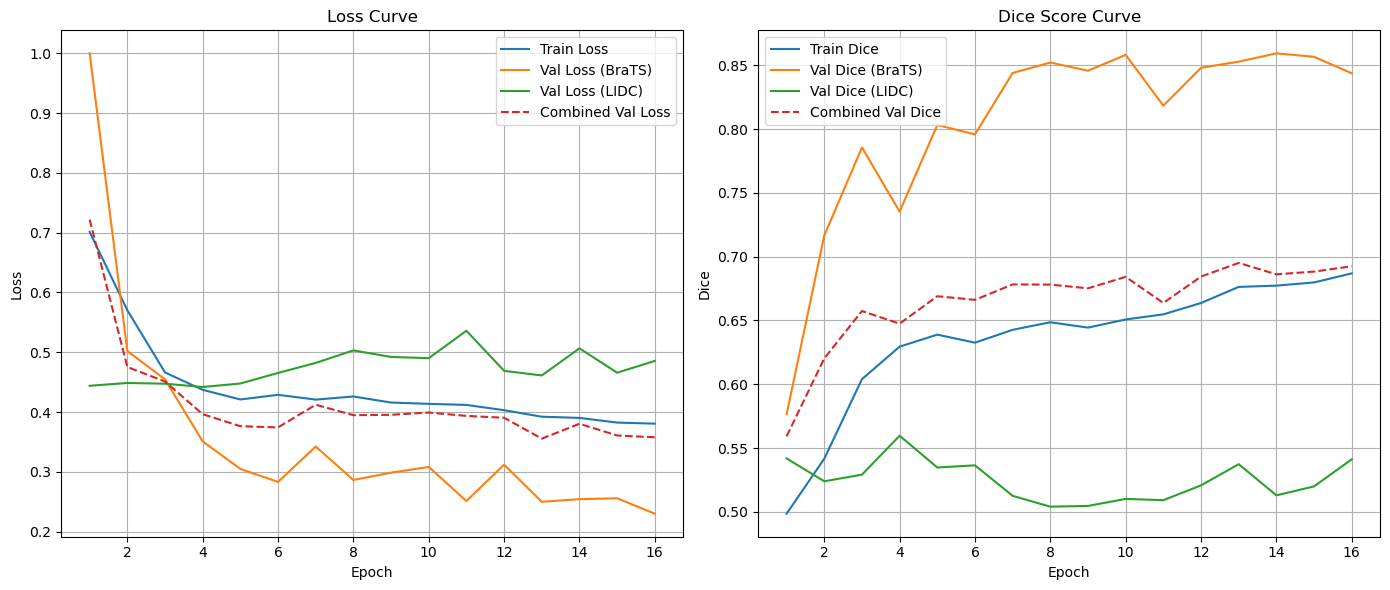

In [ ]:
import matplotlib.pyplot as plt

epochs = list(range(1, len(train_loss) + 1))

plt.figure(figsize=(14, 6))

# Loss Plot 
plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss, label="Train Loss")
plt.plot(epochs, val_loss_brats, label="Val Loss (BraTS)")
plt.plot(epochs, val_loss_lidc, label="Val Loss (LIDC)")
plt.plot(epochs, val_loss_combined, '--', label="Combined Val Loss")
plt.title("Loss Curve")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)

# Dice Plot
plt.subplot(1, 2, 2)
plt.plot(epochs, train_dice, label="Train Dice")
plt.plot(epochs, val_dice_brats, label="Val Dice (BraTS)")
plt.plot(epochs, val_dice_lidc, label="Val Dice (LIDC)")
plt.plot(epochs, val_dice_combined, '--', label="Combined Val Dice")
plt.title("Dice Score Curve")
plt.xlabel("Epoch")
plt.ylabel("Dice")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()
